# Fantasy Hockey League Analysis
# Full Season Analysis through Week 10!

code written with ChatGPT 4, 4o, and o1 or Claude 3.5 Sonnet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import arcadia_pycolor as apc
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# File paths
FILE_PATH = '../Data/Yahoo-453.l.82957-Matchup.csv'
OUTPUT_DIR = '../Results/'


## 1. Data Loading and Preparation

In [2]:
def load_and_prepare_data(file_path):
    """Load and prepare the data for analysis."""
    data = pd.read_csv(file_path)
    
    # Create long format dataframe
    team_1 = data[['Week', 'Team 1 Name', 'Team 1 Points']].rename(
        columns={'Team 1 Name': 'Team', 'Team 1 Points': 'Points'})
    team_2 = data[['Week', 'Team 2 Name', 'Team 2 Points']].rename(
        columns={'Team 2 Name': 'Team', 'Team 2 Points': 'Points'})
    
    # Concatenate and reindex
    all_teams = pd.concat([team_1, team_2])
    all_teams = all_teams.set_index(['Week', 'Team']).unstack(fill_value=0).stack().reset_index()
    
    return data, all_teams

# Load data
raw_data, all_teams_data = load_and_prepare_data(FILE_PATH)

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/3563930150.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  all_teams = all_teams.set_index(['Week', 'Team']).unstack(fill_value=0).stack().reset_index()


## 2. Basic Team Statistics

In [3]:
def calculate_team_stats(data):
    """Calculate comprehensive team statistics."""
    team_stats = {}
    
    # Process each matchup
    for _, row in data.iterrows():
        # Initialize team stats if needed
        for team_name in [row['Team 1 Name'], row['Team 2 Name']]:
            if team_name not in team_stats:
                team_stats[team_name] = {
                    'total_points': 0,
                    'points_against': 0,
                    'wins': 0,
                    'losses': 0,
                    'weekly_points': [],
                    'point_differential': 0
                }
        
        # Update stats
        team_1, team_2 = row['Team 1 Name'], row['Team 2 Name']
        score_1, score_2 = row['Team 1 Points'], row['Team 2 Points']
        
        # Update Team 1
        team_stats[team_1]['total_points'] += score_1
        team_stats[team_1]['points_against'] += score_2
        team_stats[team_1]['weekly_points'].append(score_1)
        team_stats[team_1]['point_differential'] += (score_1 - score_2)
        
        # Update Team 2
        team_stats[team_2]['total_points'] += score_2
        team_stats[team_2]['points_against'] += score_1
        team_stats[team_2]['weekly_points'].append(score_2)
        team_stats[team_2]['point_differential'] += (score_2 - score_1)
        
        # Update wins/losses
        if score_1 > score_2:
            team_stats[team_1]['wins'] += 1
            team_stats[team_2]['losses'] += 1
        else:
            team_stats[team_2]['wins'] += 1
            team_stats[team_1]['losses'] += 1
    
    # Calculate additional stats
    for team in team_stats:
        stats = team_stats[team]
        stats['avg_points'] = stats['total_points'] / len(stats['weekly_points'])
        stats['std_points'] = np.std(stats['weekly_points'])
        stats['win_rate'] = (stats['wins'] / (stats['wins'] + stats['losses'])) * 100
        
    return team_stats

# Calculate team statistics
team_stats = calculate_team_stats(raw_data)

# Print team analysis
print("Team Analysis:")
print("-" * 80)
sorted_teams = sorted(team_stats.items(), key=lambda x: x[1]['win_rate'], reverse=True)
for team, stats in sorted_teams:
    print(f"\n{team}")
    print(f"Record: {stats['wins']}-{stats['losses']} ({stats['win_rate']:.1f}% win rate)")
    print(f"Average Points: {stats['avg_points']:.1f}")
    print(f"Point Differential: {stats['point_differential']:.1f}")
    print(f"Consistency (Std Dev): {stats['std_points']:.1f}")


Team Analysis:
--------------------------------------------------------------------------------

Bad Hab-Its
Record: 9-1 (90.0% win rate)
Average Points: 323.1
Point Differential: 616.5
Consistency (Std Dev): 57.1

Chiliwack Chunderhounds
Record: 8-2 (80.0% win rate)
Average Points: 332.8
Point Differential: 591.2
Consistency (Std Dev): 62.4

Fighting Forsbergs
Record: 8-2 (80.0% win rate)
Average Points: 343.5
Point Differential: 731.3
Consistency (Std Dev): 57.8

Don't Cry I Was Olli Jokinen
Record: 7-3 (70.0% win rate)
Average Points: 316.5
Point Differential: 385.3
Consistency (Std Dev): 53.6

San Jose Barra-Cuties
Record: 6-4 (60.0% win rate)
Average Points: 334.2
Point Differential: 489.5
Consistency (Std Dev): 62.4

Jim Posac Fan Club
Record: 6-4 (60.0% win rate)
Average Points: 306.8
Point Differential: 75.4
Consistency (Std Dev): 63.9

Woonsocket Woozles
Record: 5-5 (50.0% win rate)
Average Points: 291.8
Point Differential: -28.7
Consistency (Std Dev): 40.0

Hockey???
Record: 

## 3. Comprehensive Visualization Dashboard

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/1032837906.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(all_teams['Team'].unique()))


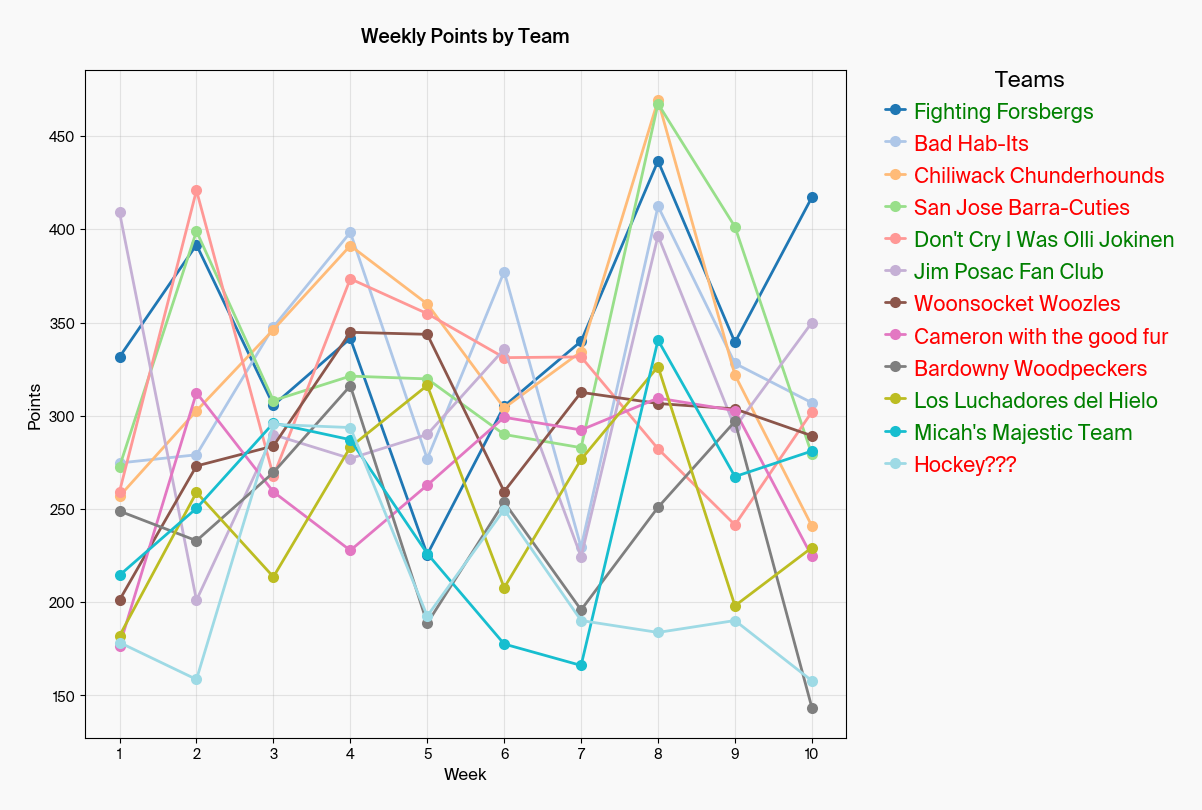

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/1032837906.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


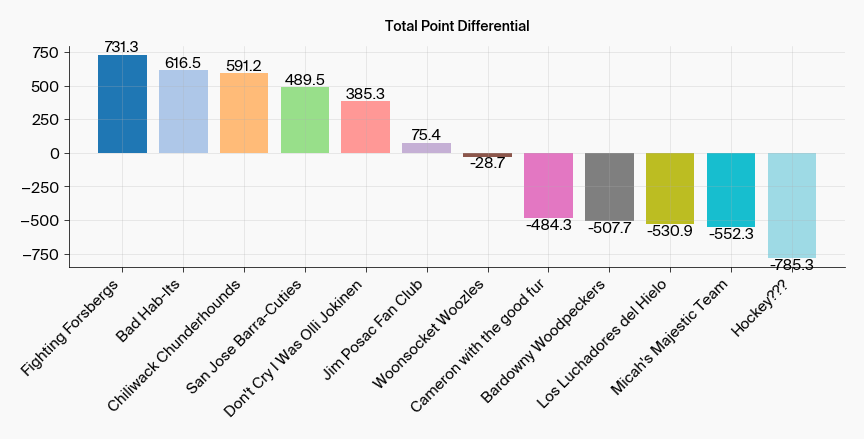

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/1032837906.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


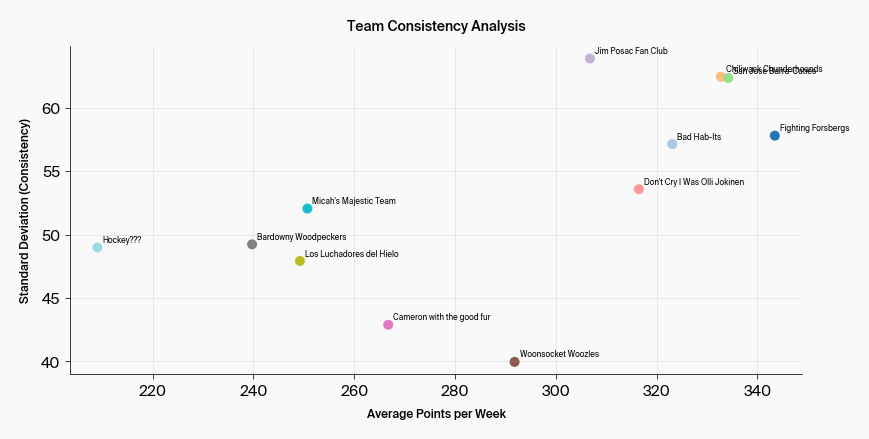

In [4]:
def plot_weekly_points(all_teams, team_stats, save_path=None):
    """Create a line plot showing weekly points for each team."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('#F9F9F9')  # Eggshell white
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams by differential for consistent coloring
    teams_by_diff = sorted(team_stats.items(), 
                          key=lambda x: x[1]['point_differential'],
                          reverse=True)
    team_order = [team[0] for team in teams_by_diff]
    
    # Setup colors
    colors = plt.cm.get_cmap('tab20', len(all_teams['Team'].unique()))
    handles, labels, slopes = [], [], []
    
    for i, team in enumerate(team_order):
        team_data = all_teams[all_teams['Team'] == team]
        recent_slope = (team_data['Points'].iloc[-1] - team_data['Points'].iloc[-2]) if len(team_data) > 1 else 0
        slopes.append(recent_slope)
        
        handle, = ax.plot(team_data['Week'], team_data['Points'], 
                          marker='o', label=team,
                          color=colors(i / len(team_order)),
                          linewidth=2, markersize=8)
        handles.append(handle)
        labels.append(team)
    
    ax.set_title('Weekly Points by Team', fontsize=14, pad=20)
    ax.set_xlabel('Week', fontsize=12)
    ax.set_ylabel('Points', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(min(all_teams['Week']), max(all_teams['Week']) + 1, 1))
    
    legend = ax.legend(handles=handles, labels=labels, 
                      title="Teams", bbox_to_anchor=(1.05, 1),
                      loc='upper left')
    
    for text, slope in zip(legend.get_texts(), slopes):
        text.set_color('green' if slope > 0 else 'red')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def plot_point_differential(team_stats, save_path=None):
    """Create a bar plot showing total point differential for each team."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')  # Eggshell white
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams by differential
    differentials = [(team, stats['point_differential']) 
                    for team, stats in team_stats.items()]
    differentials.sort(key=lambda x: x[1], reverse=True)
    teams, diffs = zip(*differentials)
    
    # Setup colors
    colors = plt.cm.get_cmap('tab20', len(teams))
    bars = ax.bar(range(len(teams)), diffs, 
                  color=[colors(i / len(teams)) for i in range(len(teams))])
    
    ax.set_title('Total Point Differential', fontsize=14)
    ax.set_xticks(range(len(teams)))
    ax.set_xticklabels(teams, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.1f}',
                ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def plot_consistency_analysis(team_stats, save_path=None):
    """Create a scatter plot analyzing team consistency."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')  # Eggshell white
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams and prepare data
    teams = sorted(team_stats.keys(), 
                  key=lambda x: team_stats[x]['point_differential'],
                  reverse=True)
    avg_points = [team_stats[team]['avg_points'] for team in teams]
    std_points = [team_stats[team]['std_points'] for team in teams]
    
    # Setup colors and create scatter plot
    colors = plt.cm.get_cmap('tab20', len(teams))
    ax.scatter(avg_points, std_points, 
              c=[colors(i / len(teams)) for i in range(len(teams))],
              s=100)
    
    # Add team labels
    for i, team in enumerate(teams):
        ax.annotate(team, (avg_points[i], std_points[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_title('Team Consistency Analysis', fontsize=14)
    ax.set_xlabel('Average Points per Week', fontsize=12)
    ax.set_ylabel('Standard Deviation (Consistency)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Example usage:
# Plot each visualization separately
plot_weekly_points(all_teams_data, team_stats, f"{OUTPUT_DIR}weekly_points.png")
plot_point_differential(team_stats, f"{OUTPUT_DIR}point_differential.png")
plot_consistency_analysis(team_stats, f"{OUTPUT_DIR}consistency_analysis.png")

## 4. Total Points Analysis

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/1507620135.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(total_points_per_team))


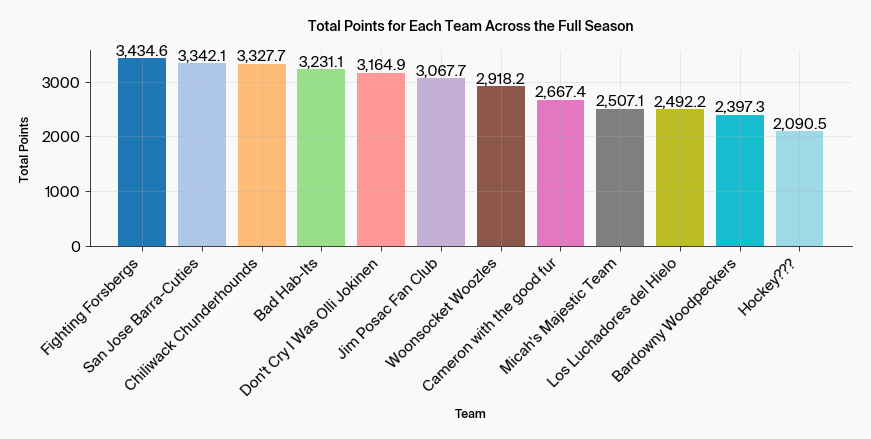

In [5]:
def plot_total_points(raw_data, save_path=None):
    """Create a styled bar plot showing total points for each hockey team."""
    # Data preparation
    team_1_total = raw_data[['Team 1 Name', 'Team 1 Points']].rename(
        columns={'Team 1 Name': 'Team', 'Team 1 Points': 'Points'})
    team_2_total = raw_data[['Team 2 Name', 'Team 2 Points']].rename(
        columns={'Team 2 Name': 'Team', 'Team 2 Points': 'Points'})

    all_teams_total = pd.concat([team_1_total, team_2_total])
    total_points_per_team = all_teams_total.groupby('Team')['Points'].sum().sort_values(ascending=False)
    
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')  # Eggshell white
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Setup colors
    colors = plt.cm.get_cmap('tab20', len(total_points_per_team))
    
    # Create bar plot
    bars = ax.bar(range(len(total_points_per_team)), 
                 total_points_per_team.values,
                 color=[colors(i / len(total_points_per_team)) for i in range(len(total_points_per_team))])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.1f}',
                ha='center', va='bottom')
    
    # Customize plot
    ax.set_title('Total Points for Each Team Across the Full Season', fontsize=14, pad=20)
    ax.set_xlabel('Team', fontsize=12)
    ax.set_ylabel('Total Points', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set x-ticks with team names
    ax.set_xticks(range(len(total_points_per_team)))
    ax.set_xticklabels(total_points_per_team.index,
                      rotation=45,
                      ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()
    
    return total_points_per_team

# Usage
total_points = plot_total_points(raw_data, f"{OUTPUT_DIR}FanHockeyTotals.png")

## 5. Statistical Analysis

In [6]:
# Perform ANOVA
anova_model = ols('Points ~ C(Team)', data=all_teams_data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print("ANOVA Results:")
print(anova_table)

# Post-hoc analysis if ANOVA is significant
if anova_table['PR(>F)'].iloc[0] < 0.05:
    print("\nPerforming Tukey's HSD post-hoc test...")
    tukey = pairwise_tukeyhsd(endog=all_teams_data['Points'], 
                             groups=all_teams_data['Team'], 
                             alpha=0.05)
    print(tukey)
    
    tukey_results = pd.DataFrame(data=tukey._results_table.data[1:], 
                                columns=tukey._results_table.data[0])
    print("\nSignificant pairwise comparisons (p < 0.05):")
    print(tukey_results[tukey_results['p-adj'] < 0.05][['group1', 'group2', 'p-adj']])

ANOVA Results:
                 sum_sq     df         F        PR(>F)
C(Team)   215309.010667   11.0  6.107474  1.037385e-07
Residual  346123.924000  108.0       NaN           NaN

Performing Tukey's HSD post-hoc test...
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
           group1                       group2            meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------------------------------
                 Bad Hab-Its         Bardowny Woodpeckers   -83.38 0.0571 -167.9635   1.2035  False
                 Bad Hab-Its    Cameron with the good fur   -56.37 0.5346 -140.9535  28.2135  False
                 Bad Hab-Its      Chiliwack Chunderhounds     9.66    1.0  -74.9235  94.2435  False
                 Bad Hab-Its Don't Cry I Was Olli Jokinen    -6.62    1.0  -91.2035  77.9635  False
                 Bad Hab-Its           Fighting Forsbergs    20.35 0.9997  -64.

## 6. Team vs League Average Analysis

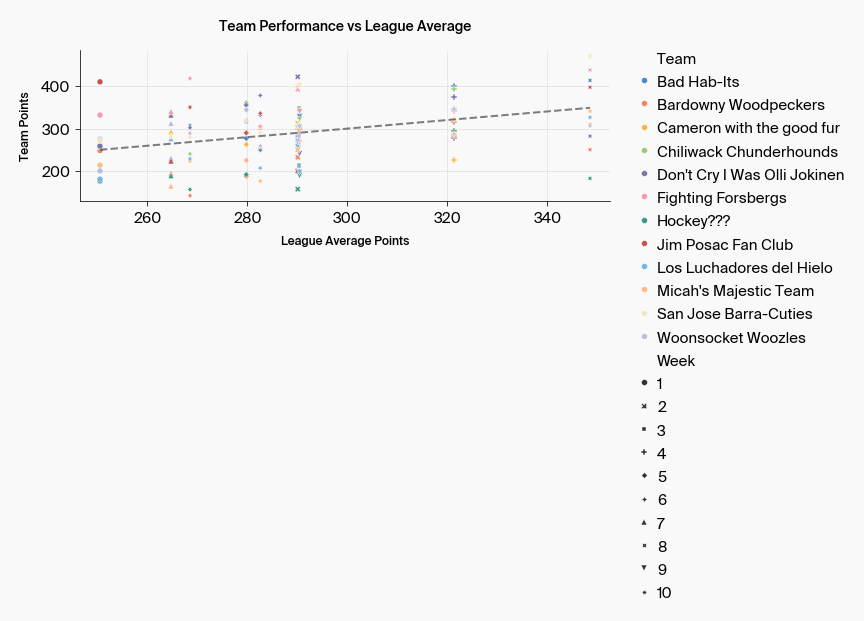


Notable Differences from League Average (>50 points):
                             Team  Week  Team Points  League Average  \
70             Jim Posac Fan Club     1        409.1      250.516667   
59             Fighting Forsbergs    10        417.2      268.516667   
41   Don't Cry I Was Olli Jokinen     2        420.9      290.075000   
37        Chiliwack Chunderhounds     8        469.2      348.533333   
107         San Jose Barra-Cuties     8        467.4      348.533333   
108         San Jose Barra-Cuties     9        401.4      290.441667   
101         San Jose Barra-Cuties     2        399.0      290.075000   
51             Fighting Forsbergs     2        391.7      290.075000   
5                     Bad Hab-Its     6        377.3      282.583333   
57             Fighting Forsbergs     8        436.7      348.533333   
79             Jim Posac Fan Club    10        350.0      268.516667   
50             Fighting Forsbergs     1        331.6      250.516667   
34       

In [7]:
def analyze_team_vs_league(all_teams_data, OUTPUT_DIR):
    """Analyze team performance against league average and create visualizations."""
    # Calculate league average per week
    league_average_per_week = all_teams_data.groupby('Week')['Points'].mean()

    # Perform analysis
    team_vs_league_results = []
    for team in all_teams_data['Team'].unique():
        team_points = all_teams_data[all_teams_data['Team'] == team]

        for week in team_points['Week'].unique():
            team_week_points = team_points[team_points['Week'] == week]['Points']
            league_avg = league_average_per_week[week]

            if not team_week_points.empty:
                value = team_week_points.values[0]
                difference = value - league_avg

                team_vs_league_results.append({
                    'Team': team,
                    'Week': week,
                    'Team Points': value,
                    'League Average': league_avg,
                    'Difference': difference,
                    'Above/Below': 'Above' if difference > 0 else 'Below'
                })

    # Convert to DataFrame and save
    team_vs_league_df = pd.DataFrame(team_vs_league_results)
    team_vs_league_df.to_csv(f"{OUTPUT_DIR}team_vs_league_analysis.csv", index=False)

    return team_vs_league_df

def plot_team_vs_league_comparison(team_vs_league_df, save_path=None):
    """Create scatter plot of team performance vs league average."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')

    # Setup Arcadia color scheme
    apc.mpl.setup()

    # Create scatter plot
    sns.scatterplot(data=team_vs_league_df, 
                   x='League Average', 
                   y='Team Points', 
                   hue='Team', 
                   style='Week',
                   ax=ax)

    # Add reference line
    min_avg = team_vs_league_df['League Average'].min()
    max_avg = team_vs_league_df['League Average'].max()
    ax.plot([min_avg, max_avg],
            [min_avg, max_avg],
            'k--', alpha=0.5)

    # Customize plot
    ax.set_title('Team Performance vs League Average', fontsize=14, pad=20)
    ax.set_xlabel('League Average Points', fontsize=12)
    ax.set_ylabel('Team Points', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Adjust legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def analyze_notable_differences(team_vs_league_df, threshold=50):
    """Analyze and display notable differences from league average."""
    notable_diff = team_vs_league_df[abs(team_vs_league_df['Difference']) > threshold].sort_values('Difference', ascending=False)
    print(f"\nNotable Differences from League Average (>{threshold} points):")
    print(notable_diff[['Team', 'Week', 'Team Points', 'League Average', 'Difference', 'Above/Below']])

    # Calculate team performance metrics
    team_performance = team_vs_league_df.groupby('Team').agg({
        'Difference': ['mean', 'std'],
        'Above/Below': lambda x: (x == 'Above').mean() * 100
    }).round(2)

    team_performance.columns = ['Avg Diff vs League', 'Std Diff', '% Weeks Above Avg']
    team_performance = team_performance.sort_values('Avg Diff vs League', ascending=False)

    print("\nTeam Performance vs League Average:")
    print(team_performance)

    return notable_diff, team_performance

# Usage
team_vs_league_df = analyze_team_vs_league(all_teams_data, OUTPUT_DIR)
plot_team_vs_league_comparison(team_vs_league_df, f"{OUTPUT_DIR}team_vs_league_comparison.png")
notable_differences, team_performance = analyze_notable_differences(team_vs_league_df, threshold=50)

## 8. Home/Away Performance Analysis

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


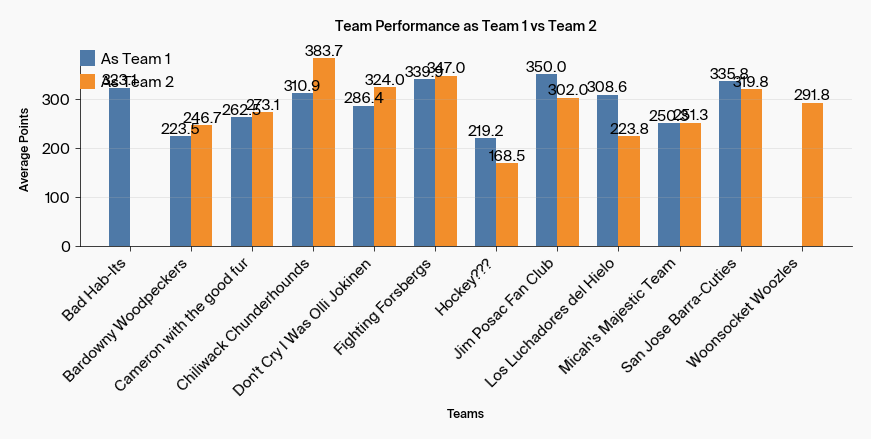


Team 1 vs Team 2 Performance:
                            Team  Avg as Team 1  Avg as Team 2  \
8       Los Luchadores del Hielo     308.633333     223.757143   
6                      Hockey???     219.187500     168.500000   
7             Jim Posac Fan Club     350.000000     301.966667   
10         San Jose Barra-Cuties     335.811111     319.800000   
9          Micah's Majestic Team     250.316667     251.300000   
5             Fighting Forsbergs     339.940000     346.980000   
2      Cameron with the good fur     262.483333     273.125000   
1           Bardowny Woodpeckers     223.533333     246.671429   
4   Don't Cry I Was Olli Jokinen     286.350000     324.025000   
3        Chiliwack Chunderhounds     310.942857     383.700000   
0                    Bad Hab-Its     323.110000            NaN   
11            Woonsocket Woozles            NaN     291.820000   

    Games as Team 1  Games as Team 2  Diff (Team 1 - Team 2)  
8                 3                7           

In [8]:
def analyze_home_away_performance(all_teams_data, raw_data):
    """Analyze team performance differences between Team 1 ('home') and Team 2 ('away') positions."""
    home_away_stats = []
    
    for team in all_teams_data['Team'].unique():
        team1_games = raw_data[raw_data['Team 1 Name'] == team]['Team 1 Points']
        team2_games = raw_data[raw_data['Team 2 Name'] == team]['Team 2 Points']
        
        stats = {
            'Team': team,
            'Avg as Team 1': team1_games.mean(),
            'Avg as Team 2': team2_games.mean(),
            'Games as Team 1': len(team1_games),
            'Games as Team 2': len(team2_games),
            'Diff (Team 1 - Team 2)': team1_games.mean() - team2_games.mean()
        }
        home_away_stats.append(stats)
    
    home_away_df = pd.DataFrame(home_away_stats)
    return home_away_df

def plot_home_away_comparison(home_away_df, save_path=None):
    """Create a bar plot comparing team performance as Team 1 vs Team 2."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Setup bar positions
    x = range(len(home_away_df))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x, home_away_df['Avg as Team 1'], 
                  width, 
                  label='As Team 1', 
                  color='#4E79A7')  # Darker blue
    bars2 = ax.bar([i + width for i in x], 
                  home_away_df['Avg as Team 2'], 
                  width, 
                  label='As Team 2', 
                  color='#F28E2B')  # Orange
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Customize plot
    ax.set_title('Team Performance as Team 1 vs Team 2', fontsize=14, pad=20)
    ax.set_xlabel('Teams', fontsize=12)
    ax.set_ylabel('Average Points', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set x-ticks
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(home_away_df['Team'], rotation=45, ha='right')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def display_home_away_analysis(home_away_df):
    """Display the home/away analysis results."""
    print("\nTeam 1 vs Team 2 Performance:")
    sorted_results = home_away_df.sort_values('Diff (Team 1 - Team 2)', ascending=False)
    print(sorted_results)
    return sorted_results

# Usage
home_away_df = analyze_home_away_performance(all_teams_data, raw_data)
plot_home_away_comparison(home_away_df, f"{OUTPUT_DIR}home_away_analysis.png")
sorted_results = display_home_away_analysis(home_away_df)

## 9. Rivalry Analysis
### Let's analyze the most lopsided and competitive matchups

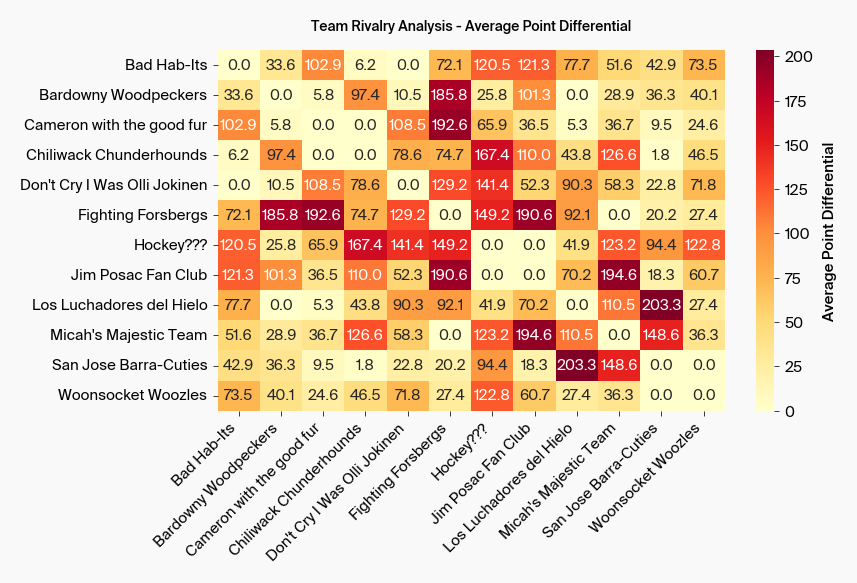


3 Most Lopsided Matchups:
                       Team 1                 Team 2  \
56   Los Luchadores del Hielo  San Jose Barra-Cuties   
52         Jim Posac Fan Club  Micah's Majestic Team   
20  Cameron with the good fur     Fighting Forsbergs   

    Average Point Differential  Team 1 Wins  Team 2 Wins  
56                       203.3            0            1  
52                       194.6            1            0  
20                       192.6            0            1  

3 Closest Matchups:
                       Team 1                     Team 2  \
33    Chiliwack Chunderhounds      San Jose Barra-Cuties   
23  Cameron with the good fur   Los Luchadores del Hielo   
10       Bardowny Woodpeckers  Cameron with the good fur   

    Average Point Differential  Team 1 Wins  Team 2 Wins  
33                         1.8            1            0  
23                         5.3            0            1  
10                         5.8            0            1  


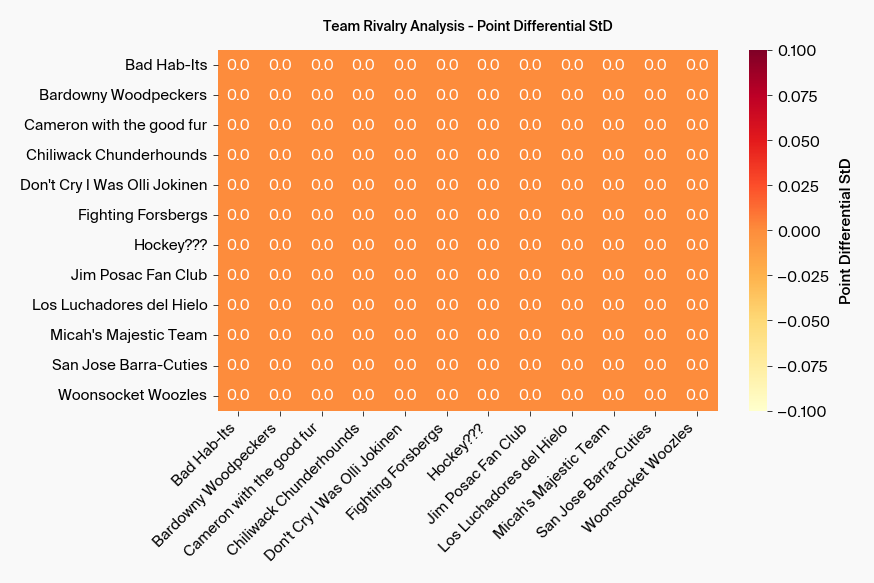

In [9]:
def analyze_team_matchups(all_teams_data, raw_data):
    """Analyze head-to-head matchups between all team pairs."""
    matchups = []
    
    # Get all unique team pairs and their matchup results
    for team1 in all_teams_data['Team'].unique():
        for team2 in all_teams_data['Team'].unique():
            if team1 < team2:  # Avoid duplicates and self-matchups
                # Find games between these teams
                matchup_games = raw_data[
                    ((raw_data['Team 1 Name'] == team1) & (raw_data['Team 2 Name'] == team2)) |
                    ((raw_data['Team 1 Name'] == team2) & (raw_data['Team 2 Name'] == team1))
                ]
                
                if not matchup_games.empty:
                    point_diffs = []
                    team1_wins = 0
                    team2_wins = 0
                    
                    for _, game in matchup_games.iterrows():
                        if game['Team 1 Name'] == team1:
                            diff = game['Team 1 Points'] - game['Team 2 Points']
                            if diff > 0:
                                team1_wins += 1
                            else:
                                team2_wins += 1
                        else:
                            diff = game['Team 2 Points'] - game['Team 1 Points']
                            if diff > 0:
                                team1_wins += 1
                            else:
                                team2_wins += 1
                        point_diffs.append(abs(diff))
                    
                    matchups.append({
                        'Team 1': team1,
                        'Team 2': team2,
                        'Games Played': len(matchup_games),
                        'Average Point Differential': np.mean(point_diffs),
                        'Team 1 Wins': team1_wins,
                        'Team 2 Wins': team2_wins,
                        'Point Differential StD': np.std(point_diffs),
                        'Total Games': len(matchup_games)
                    })
    
    return pd.DataFrame(matchups)

def plot_rivalry_heatmap(matchups_df, metric='Average Point Differential', save_path=None):
    """Create a heatmap visualization of rivalry metrics."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Prepare data for heatmap
    all_teams = sorted(list(set(matchups_df['Team 1'].unique()) | set(matchups_df['Team 2'].unique())))
    heatmap_data = np.zeros((len(all_teams), len(all_teams)))
    
    # Fill heatmap data
    for _, row in matchups_df.iterrows():
        i = all_teams.index(row['Team 1'])
        j = all_teams.index(row['Team 2'])
        heatmap_data[i, j] = row[metric]
        heatmap_data[j, i] = row[metric]  # Mirror the data
    
    # Create heatmap
    sns.heatmap(heatmap_data,
                xticklabels=all_teams,
                yticklabels=all_teams,
                cmap='YlOrRd',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': metric},
                ax=ax)
    
    # Customize plot
    ax.set_title(f'Team Rivalry Analysis - {metric}', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def display_rivalry_analysis(matchups_df, top_n=3):
    """Display most lopsided and closest matchups."""
    print(f"\n{top_n} Most Lopsided Matchups:")
    print(matchups_df.nlargest(top_n, 'Average Point Differential')[
        ['Team 1', 'Team 2', 'Average Point Differential', 'Team 1 Wins', 'Team 2 Wins']])
    
    print(f"\n{top_n} Closest Matchups:")
    print(matchups_df.nsmallest(top_n, 'Average Point Differential')[
        ['Team 1', 'Team 2', 'Average Point Differential', 'Team 1 Wins', 'Team 2 Wins']])
    
    return {
        'most_lopsided': matchups_df.nlargest(top_n, 'Average Point Differential'),
        'closest': matchups_df.nsmallest(top_n, 'Average Point Differential')
    }

# Usage
matchups_df = analyze_team_matchups(all_teams_data, raw_data)
plot_rivalry_heatmap(matchups_df, 'Average Point Differential', f"{OUTPUT_DIR}rivalry_heatmap.png")
rivalry_results = display_rivalry_analysis(matchups_df, top_n=3)

# Optional: Create additional visualization for point differential stability
plot_rivalry_heatmap(matchups_df, 'Point Differential StD', f"{OUTPUT_DIR}rivalry_stability_heatmap.png")

## 10. Momentum Analysis
### Let's analyze how teams perform after wins vs losses

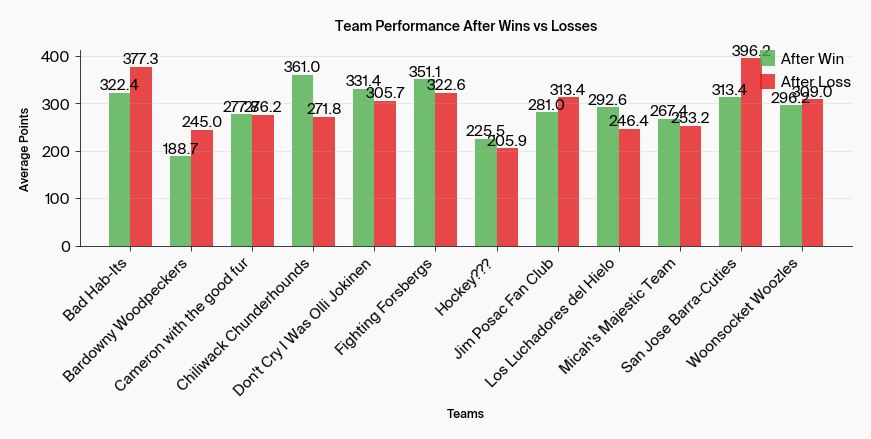

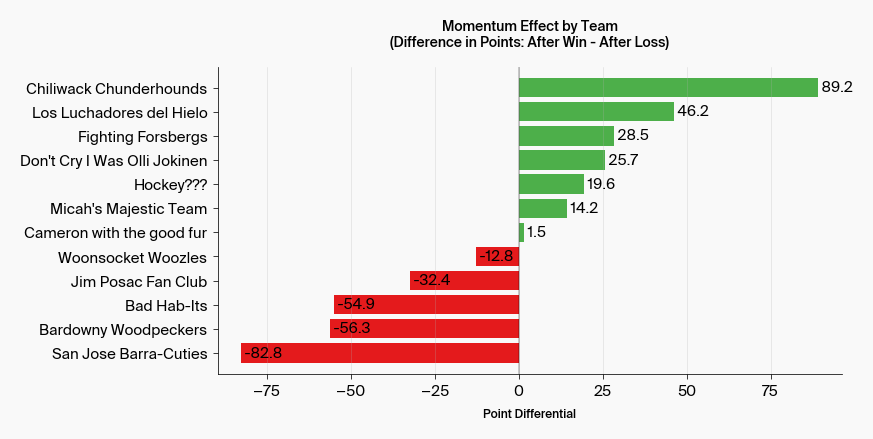


Momentum Analysis:
                            Team  Avg Points After Win  Avg Points After Loss  \
3        Chiliwack Chunderhounds            361.028571             271.800000   
8       Los Luchadores del Hielo            292.650000             246.414286   
5             Fighting Forsbergs            351.114286             322.600000   
4   Don't Cry I Was Olli Jokinen            331.400000             305.700000   
6                      Hockey???            225.500000             205.933333   
9          Micah's Majestic Team            267.400000             253.150000   
2      Cameron with the good fur            277.766667             276.233333   
11            Woonsocket Woozles            296.200000             309.000000   
7             Jim Posac Fan Club            281.000000             313.400000   
0                    Bad Hab-Its            322.387500             377.300000   
1           Bardowny Woodpeckers            188.700000             244.962500   
10      

In [10]:
def process_team_games(raw_data, team):
    """Process all games for a specific team and return chronological game data."""
    team_games = []
    
    for _, row in raw_data.iterrows():
        if row['Team 1 Name'] == team:
            won = row['Team 1 Points'] > row['Team 2 Points']
            points = row['Team 1 Points']
        elif row['Team 2 Name'] == team:
            won = row['Team 2 Points'] > row['Team 1 Points']
            points = row['Team 2 Points']
        else:
            continue
            
        team_games.append({
            'Week': row['Week'],
            'Won': won,
            'Points': points
        })
    
    return sorted(team_games, key=lambda x: x['Week'])

def analyze_momentum_stats(all_teams_data, raw_data):
    """Analyze team performance after wins and losses."""
    momentum_stats = []
    
    for team in all_teams_data['Team'].unique():
        team_games = process_team_games(raw_data, team)
        
        # Calculate performance after wins and losses
        points_after_win = []
        points_after_loss = []
        
        for i in range(1, len(team_games)):
            if team_games[i-1]['Won']:
                points_after_win.append(team_games[i]['Points'])
            else:
                points_after_loss.append(team_games[i]['Points'])
        
        momentum_stats.append({
            'Team': team,
            'Avg Points After Win': np.mean(points_after_win) if points_after_win else 0,
            'Avg Points After Loss': np.mean(points_after_loss) if points_after_loss else 0,
            'Games After Win': len(points_after_win),
            'Games After Loss': len(points_after_loss),
            'Momentum Effect': np.mean(points_after_win) - np.mean(points_after_loss) if points_after_win and points_after_loss else 0
        })
    
    return pd.DataFrame(momentum_stats)

def plot_momentum_comparison(momentum_df, save_path=None):
    """Create a bar plot comparing team performance after wins vs losses."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Setup bar positions
    teams = momentum_df['Team']
    x = range(len(teams))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x, 
                   momentum_df['Avg Points After Win'], 
                   width, 
                   label='After Win', 
                   color='#4daf4a',  # Green
                   alpha=0.8)
    bars2 = ax.bar([i + width for i in x], 
                   momentum_df['Avg Points After Loss'], 
                   width, 
                   label='After Loss', 
                   color='#e41a1c',  # Red
                   alpha=0.8)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Customize plot
    ax.set_title('Team Performance After Wins vs Losses', fontsize=14, pad=20)
    ax.set_xlabel('Teams', fontsize=12)
    ax.set_ylabel('Average Points', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set x-ticks
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(teams, rotation=45, ha='right')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def plot_momentum_effect(momentum_df, save_path=None):
    """Create a visualization of the momentum effect (difference between post-win and post-loss performance)."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort by momentum effect
    sorted_data = momentum_df.sort_values('Momentum Effect', ascending=True)
    
    # Create bars
    bars = ax.barh(range(len(sorted_data)), sorted_data['Momentum Effect'])
    
    # Color bars based on value
    for bar in bars:
        if bar.get_width() < 0:
            bar.set_color('#e41a1c')  # Red for negative
        else:
            bar.set_color('#4daf4a')  # Green for positive
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, i,
                f' {width:.1f}',
                va='center')
    
    # Customize plot
    ax.set_title('Momentum Effect by Team\n(Difference in Points: After Win - After Loss)', 
                fontsize=14, pad=20)
    ax.set_xlabel('Point Differential', fontsize=12)
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data['Team'])
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.2)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def display_momentum_analysis(momentum_df):
    """Display the momentum analysis results."""
    print("\nMomentum Analysis:")
    sorted_results = momentum_df.sort_values('Momentum Effect', ascending=False)
    print(sorted_results[['Team', 'Avg Points After Win', 'Avg Points After Loss', 'Momentum Effect']])
    return sorted_results

# Usage
momentum_df = analyze_momentum_stats(all_teams_data, raw_data)
plot_momentum_comparison(momentum_df, f"{OUTPUT_DIR}momentum_comparison.png")
plot_momentum_effect(momentum_df, f"{OUTPUT_DIR}momentum_effect.png")
momentum_results = display_momentum_analysis(momentum_df)

## 11. Score Breakdown Analysis
### Analyze the distribution of scores and identify scoring tiers

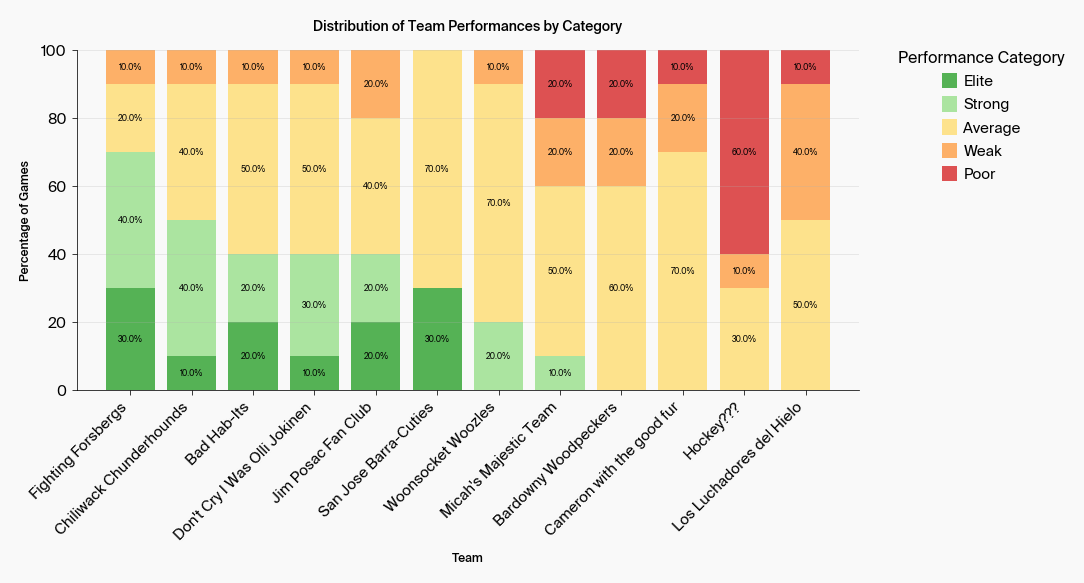


Score Thresholds:
Elite (Top 10%): ≥ 391.3
Strong (Top 25%): ≥ 331.3
Average: 288.7
Weak (Bottom 25%): ≤ 247.1
Poor (Bottom 10%): ≤ 192.4

Team Performance Summary (% of games in each category):
                        Team  Elite %  Strong %  Average %  Weak %  Poor %  Total Games
          Fighting Forsbergs     30.0      40.0       20.0    10.0     0.0           10
     Chiliwack Chunderhounds     10.0      40.0       40.0    10.0     0.0           10
                 Bad Hab-Its     20.0      20.0       50.0    10.0     0.0           10
Don't Cry I Was Olli Jokinen     10.0      30.0       50.0    10.0     0.0           10
          Jim Posac Fan Club     20.0      20.0       40.0    20.0     0.0           10
       San Jose Barra-Cuties     30.0       0.0       70.0     0.0     0.0           10
          Woonsocket Woozles      0.0      20.0       70.0    10.0     0.0           10
       Micah's Majestic Team      0.0      10.0       50.0    20.0    20.0           10
        Bard

In [11]:
def calculate_score_thresholds(raw_data):
    """Calculate score thresholds for performance categories."""
    all_scores = pd.concat([
        raw_data['Team 1 Points'],
        raw_data['Team 2 Points']
    ]).reset_index(drop=True)
    
    thresholds = {
        'Elite': float(all_scores.quantile(0.90)),
        'Strong': float(all_scores.quantile(0.75)),
        'Average': float(all_scores.mean()),
        'Weak': float(all_scores.quantile(0.25)),
        'Poor': float(all_scores.quantile(0.10))
    }
    
    return thresholds

def analyze_team_performance_distribution(all_teams_data, raw_data, thresholds):
    """Analyze each team's performance distribution across categories."""
    team_performance = []
    
    for team in all_teams_data['Team'].unique():
        # Get all scores for this team
        team_scores = pd.concat([
            raw_data[raw_data['Team 1 Name'] == team]['Team 1 Points'],
            raw_data[raw_data['Team 2 Name'] == team]['Team 2 Points']
        ]).reset_index(drop=True)
        
        total_games = len(team_scores)
        performance = {'Team': team, 'Total Games': total_games}
        
        # Count performances in each category
        performance['Elite'] = int(sum(team_scores >= thresholds['Elite']))
        performance['Strong'] = int(sum((team_scores >= thresholds['Strong']) & 
                                      (team_scores < thresholds['Elite'])))
        performance['Weak'] = int(sum((team_scores <= thresholds['Weak']) & 
                                    (team_scores > thresholds['Poor'])))
        performance['Poor'] = int(sum(team_scores <= thresholds['Poor']))
        performance['Average'] = total_games - (performance['Elite'] + performance['Strong'] + 
                                              performance['Weak'] + performance['Poor'])
        
        # Calculate percentages
        for category in ['Elite', 'Strong', 'Average', 'Weak', 'Poor']:
            performance[f'{category} %'] = round(performance[category] / total_games * 100, 1)
        
        team_performance.append(performance)
    
    performance_df = pd.DataFrame(team_performance)
    performance_df['Top Performance %'] = performance_df['Elite %'] + performance_df['Strong %']
    
    return performance_df.sort_values('Top Performance %', ascending=False)

def plot_performance_distribution(performance_df, save_path=None):
    """Create a stacked bar visualization of performance distribution."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(15, 8))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Prepare data for stacking
    categories = ['Elite', 'Strong', 'Average', 'Weak', 'Poor']
    colors = ['#2ca02c', '#98df8a', '#ffdd71', '#ff9e44', '#d62728']  # Professional color scheme
    bottom = np.zeros(len(performance_df))
    
    # Create stacked bars
    bars = []
    for cat, color in zip(categories, colors):
        bar = ax.bar(performance_df['Team'], 
                    performance_df[f'{cat} %'],
                    bottom=bottom,
                    label=cat,
                    color=color,
                    alpha=0.8)
        bars.append(bar)
        bottom += performance_df[f'{cat} %']
    
    # Add percentage labels
    for i, team in enumerate(performance_df['Team']):
        bottom = 0
        for cat in categories:
            percentage = float(performance_df.loc[performance_df['Team'] == team, f'{cat} %'].iloc[0])
            if percentage > 5:  # Only add label if there's more than 5%
                ax.text(i, bottom + percentage/2, f'{percentage:0.1f}%',
                       ha='center', va='center', fontsize=8)
            bottom += percentage
    
    # Customize plot
    ax.set_title('Distribution of Team Performances by Category', fontsize=14, pad=20)
    ax.set_xlabel('Team', fontsize=12)
    ax.set_ylabel('Percentage of Games', fontsize=12)
    ax.legend(title='Performance Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

def display_performance_analysis(performance_df, thresholds):
    """Display performance analysis results and insights."""
    print("\nScore Thresholds:")
    print(f"Elite (Top 10%): ≥ {thresholds['Elite']:.1f}")
    print(f"Strong (Top 25%): ≥ {thresholds['Strong']:.1f}")
    print(f"Average: {thresholds['Average']:.1f}")
    print(f"Weak (Bottom 25%): ≤ {thresholds['Weak']:.1f}")
    print(f"Poor (Bottom 10%): ≤ {thresholds['Poor']:.1f}")
    
    print("\nTeam Performance Summary (% of games in each category):")
    summary_cols = ['Team', 'Elite %', 'Strong %', 'Average %', 'Weak %', 'Poor %', 'Total Games']
    print(performance_df[summary_cols].to_string(index=False))
    
    print("\nKey Insights:")
    for team in performance_df['Team']:
        team_data = performance_df[performance_df['Team'] == team].iloc[0]
        top_perf = team_data['Top Performance %']
        bottom_perf = team_data['Weak %'] + team_data['Poor %']
        
        print(f"\n{team}:")
        print(f"- {top_perf:.1f}% of games were Elite/Strong performances")
        print(f"- {team_data['Average %']:.1f}% were Average performances")
        print(f"- {bottom_perf:.1f}% were Weak/Poor performances")
    
    return performance_df

# Usage
thresholds = calculate_score_thresholds(raw_data)
performance_df = analyze_team_performance_distribution(all_teams_data, raw_data, thresholds)
plot_performance_distribution(performance_df, f"{OUTPUT_DIR}score_distribution.png")
performance_analysis = display_performance_analysis(performance_df, thresholds)

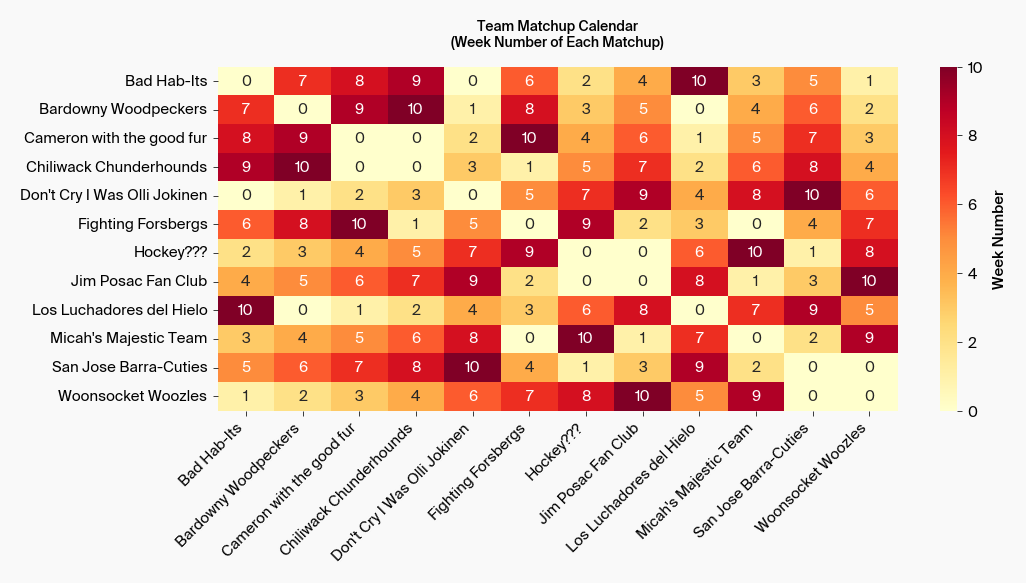

In [12]:
def plot_matchup_calendar(raw_data, save_path=None):
    """Create a calendar heatmap showing when teams played each other."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(15, 8))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Get all teams
    all_teams = sorted(list(set(raw_data['Team 1 Name'].unique()) | 
                          set(raw_data['Team 2 Name'].unique())))
    
    # Create matchup matrix
    matchup_matrix = np.zeros((len(all_teams), len(all_teams)))
    
    # Fill matrix with week numbers of matchups
    for _, row in raw_data.iterrows():
        i = all_teams.index(row['Team 1 Name'])
        j = all_teams.index(row['Team 2 Name'])
        matchup_matrix[i, j] = row['Week']
        matchup_matrix[j, i] = row['Week']  # Mirror the data
    
    # Create heatmap
    sns.heatmap(matchup_matrix,
                xticklabels=all_teams,
                yticklabels=all_teams,
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Week Number'},
                ax=ax)
    
    # Customize plot
    ax.set_title('Team Matchup Calendar\n(Week Number of Each Matchup)', 
                fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()
    
    return matchup_matrix

# Usage
matchup_matrix = plot_matchup_calendar(raw_data, f"{OUTPUT_DIR}matchup_calendar.png")

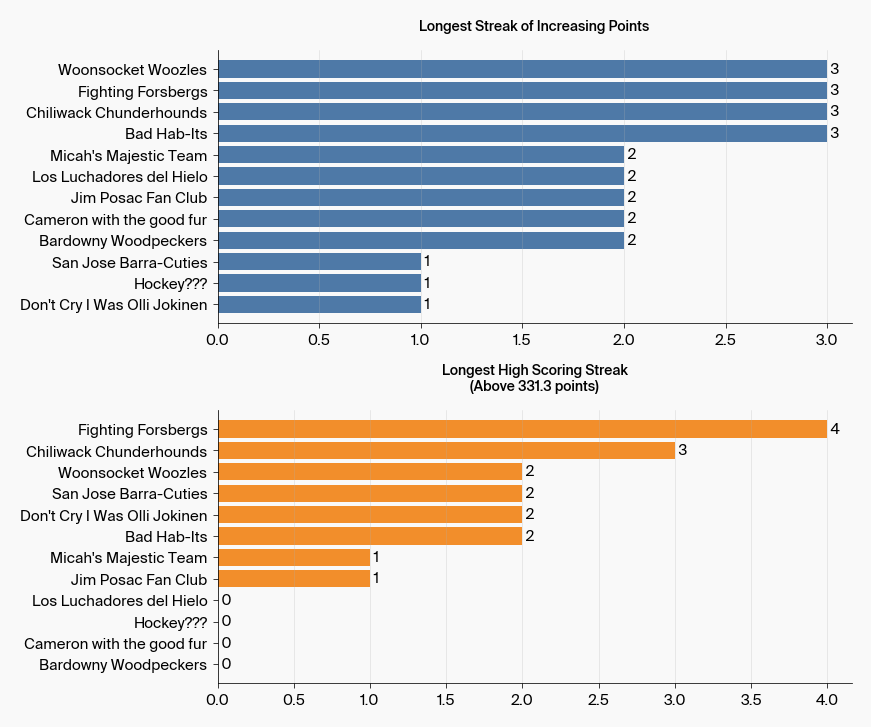

In [13]:
def analyze_scoring_streaks(all_teams_data, raw_data, threshold=None):
    """Analyze scoring streaks for each team."""
    if threshold is None:
        # Use 75th percentile as default threshold for "high scoring"
        all_scores = pd.concat([raw_data['Team 1 Points'], raw_data['Team 2 Points']])
        threshold = float(all_scores.quantile(0.75))
    
    streak_stats = []
    
    for team in all_teams_data['Team'].unique():
        team_games = []
        
        # Get all games for the team in chronological order
        for _, row in raw_data.iterrows():
            if row['Team 1 Name'] == team:
                points = row['Team 1 Points']
            elif row['Team 2 Name'] == team:
                points = row['Team 2 Points']
            else:
                continue
                
            team_games.append({
                'Week': row['Week'],
                'Points': points,
                'High Scoring': points >= threshold
            })
        
        # Sort games by week
        team_games = sorted(team_games, key=lambda x: x['Week'])
        
        # Calculate streaks
        current_streak = 0
        max_streak = 0
        high_scoring_streak = 0
        max_high_scoring = 0
        
        for i, game in enumerate(team_games):
            if i > 0:
                if game['Points'] > team_games[i-1]['Points']:
                    current_streak += 1
                else:
                    current_streak = 0
                    
                if game['High Scoring']:
                    high_scoring_streak += 1
                else:
                    high_scoring_streak = 0
                    
            max_streak = max(max_streak, current_streak)
            max_high_scoring = max(max_high_scoring, high_scoring_streak)
        
        streak_stats.append({
            'Team': team,
            'Longest Increasing Streak': max_streak,
            'Longest High Scoring Streak': max_high_scoring,
            'High Score Threshold': threshold,
            'Total Games': len(team_games)
        })
    
    return pd.DataFrame(streak_stats)

def plot_streak_analysis(streak_df, save_path=None):
    """Visualize scoring streaks analysis."""
    # Create figure with eggshell white background
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.patch.set_facecolor('#F9F9F9')
    ax1.set_facecolor('#F9F9F9')
    ax2.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams by streak length
    inc_sorted = streak_df.sort_values('Longest Increasing Streak', ascending=True)
    high_sorted = streak_df.sort_values('Longest High Scoring Streak', ascending=True)
    
    # Plot Increasing Streaks
    bars1 = ax1.barh(range(len(inc_sorted)), inc_sorted['Longest Increasing Streak'],
                     color='#4E79A7')
    ax1.set_title('Longest Streak of Increasing Points', fontsize=14, pad=20)
    ax1.set_yticks(range(len(inc_sorted)))
    ax1.set_yticklabels(inc_sorted['Team'])
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width, i, f' {width}', va='center')
    
    # Plot High Scoring Streaks
    bars2 = ax2.barh(range(len(high_sorted)), high_sorted['Longest High Scoring Streak'],
                     color='#F28E2B')
    ax2.set_title(f'Longest High Scoring Streak\n(Above {streak_df["High Score Threshold"].iloc[0]:.1f} points)',
                  fontsize=14, pad=20)
    ax2.set_yticks(range(len(high_sorted)))
    ax2.set_yticklabels(high_sorted['Team'])
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width, i, f' {width}', va='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Usage
streak_df = analyze_scoring_streaks(all_teams_data, raw_data)
plot_streak_analysis(streak_df, f"{OUTPUT_DIR}scoring_streaks.png")

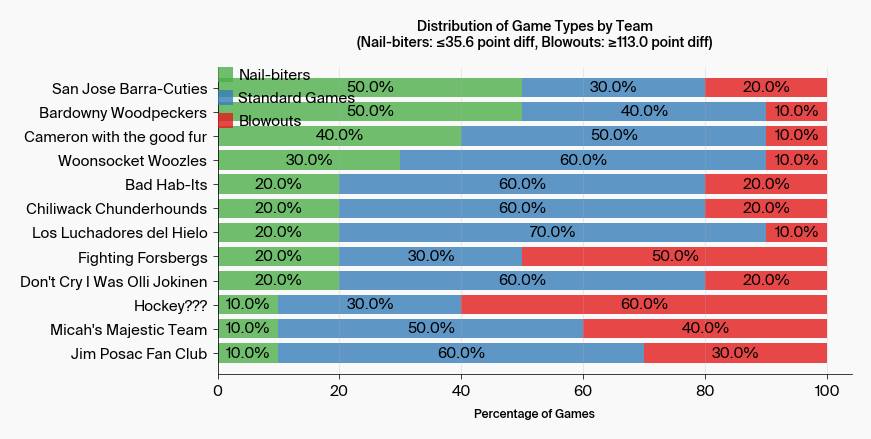

In [14]:
def analyze_game_closeness(raw_data):
    """Analyze how close games are and identify nail-biters vs blowouts."""
    # Calculate point differential for each game
    raw_data['Point_Differential'] = abs(raw_data['Team 1 Points'] - raw_data['Team 2 Points'])
    
    # Define thresholds for close games and blowouts
    close_threshold = float(raw_data['Point_Differential'].quantile(0.25))  # Bottom 25% are "close"
    blowout_threshold = float(raw_data['Point_Differential'].quantile(0.75))  # Top 25% are "blowouts"
    
    # Categorize games
    def categorize_game(diff):
        if diff <= close_threshold:
            return 'Nail-biter'
        elif diff >= blowout_threshold:
            return 'Blowout'
        else:
            return 'Standard'
    
    raw_data['Game_Type'] = raw_data['Point_Differential'].apply(categorize_game)
    
    # Analyze team involvement in different game types
    team_game_types = []
    
    for team in set(raw_data['Team 1 Name'].unique()) | set(raw_data['Team 2 Name'].unique()):
        team_games = raw_data[
            (raw_data['Team 1 Name'] == team) | 
            (raw_data['Team 2 Name'] == team)
        ]
        
        game_type_counts = team_games['Game_Type'].value_counts()
        total_games = len(team_games)
        
        team_game_types.append({
            'Team': team,
            'Total Games': total_games,
            'Nail-biters': int(game_type_counts.get('Nail-biter', 0)),
            'Standard': int(game_type_counts.get('Standard', 0)),
            'Blowouts': int(game_type_counts.get('Blowout', 0)),
            'Nail-biter %': round(game_type_counts.get('Nail-biter', 0) / total_games * 100, 1),
            'Standard %': round(game_type_counts.get('Standard', 0) / total_games * 100, 1),
            'Blowout %': round(game_type_counts.get('Blowout', 0) / total_games * 100, 1)
        })
    
    return pd.DataFrame(team_game_types), close_threshold, blowout_threshold

def plot_game_closeness(closeness_df, close_threshold, blowout_threshold, save_path=None):
    """Visualize the distribution of game types for each team."""
    # Create figure with eggshell white background
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams by percentage of nail-biters
    sorted_df = closeness_df.sort_values('Nail-biter %', ascending=True)
    
    # Create stacked bars
    bottom = np.zeros(len(sorted_df))
    categories = ['Nail-biter %', 'Standard %', 'Blowout %']
    colors = ['#4daf4a', '#377eb8', '#e41a1c']
    labels = ['Nail-biters', 'Standard Games', 'Blowouts']
    
    for cat, color, label in zip(categories, colors, labels):
        ax.barh(range(len(sorted_df)), sorted_df[cat], left=bottom, 
                color=color, alpha=0.8, label=label)
        bottom += sorted_df[cat]
    
    # Customize plot
    ax.set_title('Distribution of Game Types by Team\n' + 
                f'(Nail-biters: ≤{close_threshold:.1f} point diff, ' +
                f'Blowouts: ≥{blowout_threshold:.1f} point diff)',
                fontsize=14, pad=20)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Team'])
    ax.set_xlabel('Percentage of Games', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, team in enumerate(sorted_df['Team']):
        x = 0
        for cat in categories:
            percentage = float(sorted_df.loc[sorted_df['Team'] == team, cat].iloc[0])
            if percentage > 5:  # Only show if > 5%
                ax.text(x + percentage/2, i, f'{percentage:.1f}%',
                       ha='center', va='center')
            x += percentage
    
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Usage
closeness_df, close_threshold, blowout_threshold = analyze_game_closeness(raw_data)
plot_game_closeness(closeness_df, close_threshold, blowout_threshold, 
                   f"{OUTPUT_DIR}game_closeness.png")

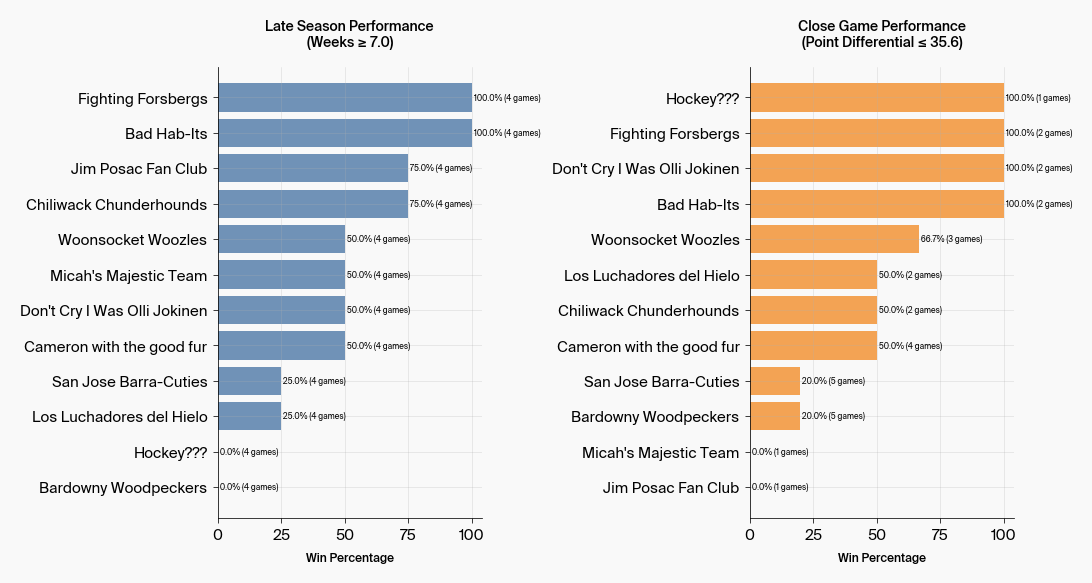

In [15]:
def analyze_clutch_performance(raw_data, all_teams_data):
    """Analyze team performance in 'clutch' situations (close games, late weeks)."""
    # Define clutch parameters
    late_season_threshold = max(raw_data['Week']) * 0.7  # Last 30% of season
    close_game_threshold = np.percentile(
        abs(raw_data['Team 1 Points'] - raw_data['Team 2 Points']), 25)  # Bottom 25% closest games
    
    clutch_stats = []
    
    for team in all_teams_data['Team'].unique():
        # Late season performance
        late_season_games = raw_data[raw_data['Week'] >= late_season_threshold]
        team_late_games = late_season_games[
            (late_season_games['Team 1 Name'] == team) |
            (late_season_games['Team 2 Name'] == team)
        ]
        
        late_wins = 0
        late_points = []
        
        for _, game in team_late_games.iterrows():
            if game['Team 1 Name'] == team:
                points = game['Team 1 Points']
                won = game['Team 1 Points'] > game['Team 2 Points']
            else:
                points = game['Team 2 Points']
                won = game['Team 2 Points'] > game['Team 1 Points']
            
            late_points.append(points)
            if won:
                late_wins += 1
        
        # Close game performance
        close_games = raw_data[
            abs(raw_data['Team 1 Points'] - raw_data['Team 2 Points']) <= close_game_threshold
        ]
        team_close_games = close_games[
            (close_games['Team 1 Name'] == team) |
            (close_games['Team 2 Name'] == team)
        ]
        
        close_wins = 0
        close_points = []
        
        for _, game in team_close_games.iterrows():
            if game['Team 1 Name'] == team:
                points = game['Team 1 Points']
                won = game['Team 1 Points'] > game['Team 2 Points']
            else:
                points = game['Team 2 Points']
                won = game['Team 2 Points'] > game['Team 1 Points']
            
            close_points.append(points)
            if won:
                close_wins += 1
        
        clutch_stats.append({
            'Team': team,
            'Late Season Win %': round(late_wins / len(team_late_games) * 100 if team_late_games.shape[0] > 0 else 0, 1),
            'Late Season Avg Points': round(np.mean(late_points) if late_points else 0, 1),
            'Close Games Win %': round(close_wins / len(team_close_games) * 100 if team_close_games.shape[0] > 0 else 0, 1),
            'Close Games Avg Points': round(np.mean(close_points) if close_points else 0, 1),
            'Late Games Played': len(team_late_games),
            'Close Games Played': len(team_close_games)
        })
    
    return pd.DataFrame(clutch_stats), late_season_threshold, close_game_threshold

def plot_clutch_performance(clutch_df, late_threshold, close_threshold, save_path=None):
    """Create visualization of clutch performance metrics."""
    # Create figure with eggshell white background
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    fig.patch.set_facecolor('#F9F9F9')
    ax1.set_facecolor('#F9F9F9')
    ax2.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Plot 1: Late Season Performance
    late_sorted = clutch_df.sort_values('Late Season Win %', ascending=True)
    bars1 = ax1.barh(range(len(late_sorted)), late_sorted['Late Season Win %'],
                     color='#4E79A7', alpha=0.8)
    
    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        games = late_sorted.iloc[i]['Late Games Played']
        ax1.text(width, i, f' {width:.1f}% ({games} games)',
                va='center', fontsize=8)
    
    ax1.set_title(f'Late Season Performance\n(Weeks ≥ {late_threshold:.1f})',
                  fontsize=14, pad=20)
    ax1.set_yticks(range(len(late_sorted)))
    ax1.set_yticklabels(late_sorted['Team'])
    ax1.set_xlabel('Win Percentage', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Close Game Performance
    close_sorted = clutch_df.sort_values('Close Games Win %', ascending=True)
    bars2 = ax2.barh(range(len(close_sorted)), close_sorted['Close Games Win %'],
                     color='#F28E2B', alpha=0.8)
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        games = close_sorted.iloc[i]['Close Games Played']
        ax2.text(width, i, f' {width:.1f}% ({games} games)',
                va='center', fontsize=8)
    
    ax2.set_title(f'Close Game Performance\n(Point Differential ≤ {close_threshold:.1f})',
                  fontsize=14, pad=20)
    ax2.set_yticks(range(len(close_sorted)))
    ax2.set_yticklabels(close_sorted['Team'])
    ax2.set_xlabel('Win Percentage', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Usage
clutch_df, late_threshold, close_threshold = analyze_clutch_performance(raw_data, all_teams_data)
plot_clutch_performance(clutch_df, late_threshold, close_threshold, f"{OUTPUT_DIR}clutch_performance.png")

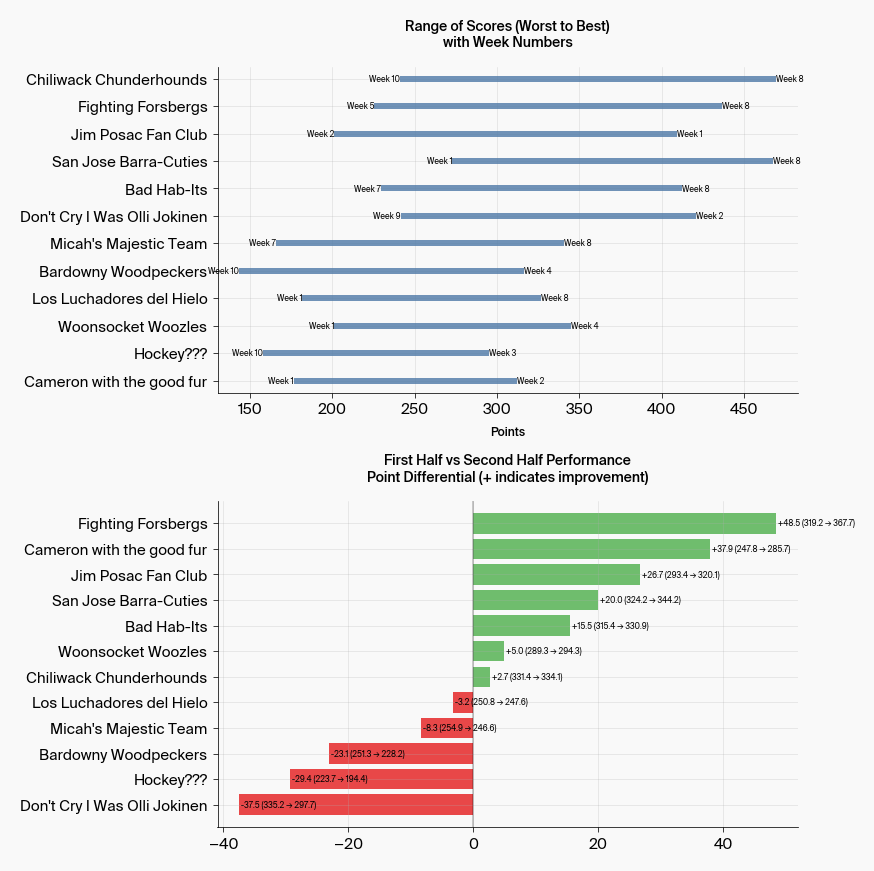

In [16]:
def analyze_scoring_patterns(raw_data, all_teams_data):
    """Analyze when teams tend to have their best and worst performances."""
    pattern_stats = []
    
    for team in all_teams_data['Team'].unique():
        team_scores = []
        
        # Collect all scores for the team
        for _, row in raw_data.iterrows():
            week = row['Week']
            if row['Team 1 Name'] == team:
                points = row['Team 1 Points']
            elif row['Team 2 Name'] == team:
                points = row['Team 2 Points']
            else:
                continue
            
            team_scores.append({
                'Week': week,
                'Points': points
            })
        
        # Sort by week
        team_scores = sorted(team_scores, key=lambda x: x['Week'])
        
        # Find best and worst performances
        best_game = max(team_scores, key=lambda x: x['Points'])
        worst_game = min(team_scores, key=lambda x: x['Points'])
        
        # Calculate first half vs second half performance
        mid_week = max(raw_data['Week']) / 2
        first_half = [g['Points'] for g in team_scores if g['Week'] <= mid_week]
        second_half = [g['Points'] for g in team_scores if g['Week'] > mid_week]
        
        pattern_stats.append({
            'Team': team,
            'Best Week': best_game['Week'],
            'Best Score': best_game['Points'],
            'Worst Week': worst_game['Week'],
            'Worst Score': worst_game['Points'],
            'First Half Avg': np.mean(first_half),
            'Second Half Avg': np.mean(second_half),
            'Improvement': np.mean(second_half) - np.mean(first_half),
            'Score Range': best_game['Points'] - worst_game['Points']
        })
    
    return pd.DataFrame(pattern_stats)

def plot_scoring_patterns(pattern_df, save_path=None):
    """Create visualizations of scoring patterns."""
    # Create figure with eggshell white background
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    fig.patch.set_facecolor('#F9F9F9')
    ax1.set_facecolor('#F9F9F9')
    ax2.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Plot 1: Best/Worst Week Distribution
    teams = pattern_df['Team']
    y_pos = range(len(teams))
    
    # Sort by score range
    sorted_df = pattern_df.sort_values('Score Range', ascending=True)
    
    # Create "floating bars" from worst to best
    ax1.hlines(y=y_pos, xmin=sorted_df['Worst Score'], xmax=sorted_df['Best Score'],
               color='#4E79A7', alpha=0.8, linewidth=6)
    
    # Add week annotations
    for idx, row in enumerate(sorted_df.iterrows()):
        row_data = row[1]  # Get the Series from the tuple
        ax1.text(row_data['Worst Score'], idx, f"Week {int(row_data['Worst Week'])}",
                ha='right', va='center', fontsize=8)
        ax1.text(row_data['Best Score'], idx, f"Week {int(row_data['Best Week'])}",
                ha='left', va='center', fontsize=8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(sorted_df['Team'])
    ax1.set_title('Range of Scores (Worst to Best)\nwith Week Numbers',
                  fontsize=14, pad=20)
    ax1.set_xlabel('Points', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: First Half vs Second Half
    improvement_sorted = pattern_df.sort_values('Improvement', ascending=True)
    
    # Create bars for improvement/decline
    bars = ax2.barh(range(len(improvement_sorted)), improvement_sorted['Improvement'],
                    color=[('#4daf4a' if x >= 0 else '#e41a1c') for x in improvement_sorted['Improvement']],
                    alpha=0.8)
    
    # Add value labels
    for i, row in enumerate(improvement_sorted.iterrows()):
        row_data = row[1]  # Get the Series from the tuple
        width = row_data['Improvement']
        first_half = row_data['First Half Avg']
        second_half = row_data['Second Half Avg']
        if width >= 0:
            ax2.text(width, i, f' +{width:.1f} ({first_half:.1f} → {second_half:.1f})',
                    va='center', fontsize=8)
        else:
            ax2.text(width, i, f' {width:.1f} ({first_half:.1f} → {second_half:.1f})',
                    va='center', fontsize=8)
    
    ax2.set_title('First Half vs Second Half Performance\nPoint Differential (+ indicates improvement)',
                  fontsize=14, pad=20)
    ax2.set_yticks(range(len(improvement_sorted)))
    ax2.set_yticklabels(improvement_sorted['Team'])
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Usage
pattern_df = analyze_scoring_patterns(raw_data, all_teams_data)
plot_scoring_patterns(pattern_df, f"{OUTPUT_DIR}scoring_patterns.png")

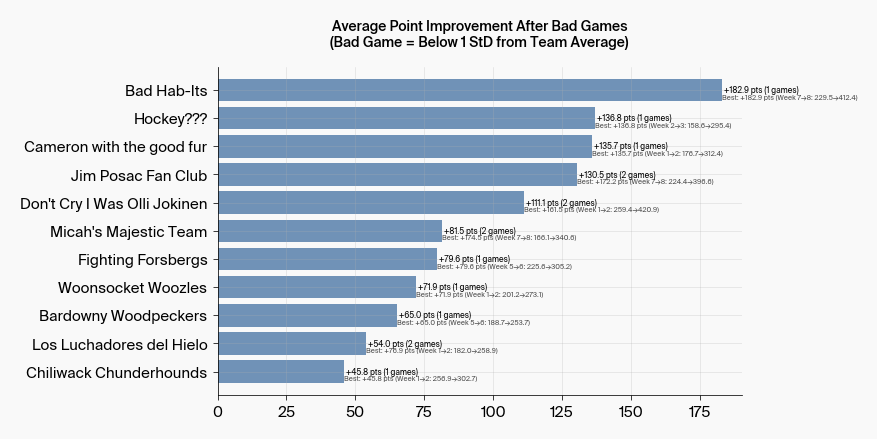

In [17]:
def analyze_bounce_back(raw_data, all_teams_data):
    """Analyze how teams perform after their worst performances."""
    bounce_back_stats = []
    
    for team in all_teams_data['Team'].unique():
        team_games = []
        
        # Get all games for the team in chronological order
        for _, row in raw_data.iterrows():
            if row['Team 1 Name'] == team:
                points = row['Team 1 Points']
                opponent = row['Team 2 Name']
            elif row['Team 2 Name'] == team:
                points = row['Team 2 Points']
                opponent = row['Team 1 Name']
            else:
                continue
                
            team_games.append({
                'Week': row['Week'],
                'Points': points,
                'Opponent': opponent
            })
        
        # Sort games by week
        team_games = sorted(team_games, key=lambda x: x['Week'])
        
        if len(team_games) < 2:  # Skip if not enough games
            continue
            
        # Calculate running averages and find bad games
        team_avg = np.mean([g['Points'] for g in team_games])
        team_std = np.std([g['Points'] for g in team_games])
        
        bad_game_threshold = team_avg - team_std
        bounce_backs = []
        
        for i in range(len(team_games)-1):
            if team_games[i]['Points'] < bad_game_threshold:
                bounce_back = {
                    'Bad Game Score': team_games[i]['Points'],
                    'Bad Game Week': team_games[i]['Week'],
                    'Bad Game Opponent': team_games[i]['Opponent'],
                    'Next Game Score': team_games[i+1]['Points'],
                    'Next Game Week': team_games[i+1]['Week'],
                    'Next Game Opponent': team_games[i+1]['Opponent'],
                    'Score Improvement': team_games[i+1]['Points'] - team_games[i]['Points']
                }
                bounce_backs.append(bounce_back)
        
        if bounce_backs:  # Only include teams with bounce back opportunities
            avg_bounce_back = np.mean([b['Score Improvement'] for b in bounce_backs])
            best_bounce = max(bounce_backs, key=lambda x: x['Score Improvement'])
            
            bounce_back_stats.append({
                'Team': team,
                'Bad Games Count': len(bounce_backs),
                'Avg Bounce Back': avg_bounce_back,
                'Best Bounce Back': best_bounce['Score Improvement'],
                'Best Bounce Week': f"{int(best_bounce['Bad Game Week'])}→{int(best_bounce['Next Game Week'])}",
                'Best Bounce Scores': f"{best_bounce['Bad Game Score']:.1f}→{best_bounce['Next Game Score']:.1f}",
                'Team Average': team_avg,
                'Bad Game Threshold': bad_game_threshold
            })
    
    return pd.DataFrame(bounce_back_stats)

def plot_bounce_back_analysis(bounce_df, save_path=None):
    """Create visualization of bounce back performance."""
    # Create figure with eggshell white background
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#F9F9F9')
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort by average bounce back
    sorted_df = bounce_df.sort_values('Avg Bounce Back', ascending=True)
    
    # Create bars
    bars = ax.barh(range(len(sorted_df)), sorted_df['Avg Bounce Back'],
                   color='#4E79A7', alpha=0.8)
    
    # Add value labels
    for i, row in enumerate(sorted_df.iterrows()):
        row_data = row[1]
        width = row_data['Avg Bounce Back']
        count = row_data['Bad Games Count']
        best_bounce = row_data['Best Bounce Back']
        best_week = row_data['Best Bounce Week']
        best_scores = row_data['Best Bounce Scores']
        
        # Add average bounce back value
        ax.text(width, i, f' +{width:.1f} pts ({count} games)',
                va='center', ha='left', fontsize=8)
        
        # Add best bounce back details
        ax.text(width, i - 0.25, 
                f'Best: +{best_bounce:.1f} pts (Week {best_week}: {best_scores})',
                va='center', ha='left', fontsize=7, alpha=0.7)
    
    ax.set_title('Average Point Improvement After Bad Games\n(Bad Game = Below 1 StD from Team Average)',
                 fontsize=14, pad=20)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Team'])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()

# Usage
bounce_df = analyze_bounce_back(raw_data, all_teams_data)
plot_bounce_back_analysis(bounce_df, f"{OUTPUT_DIR}bounce_back_analysis.png")

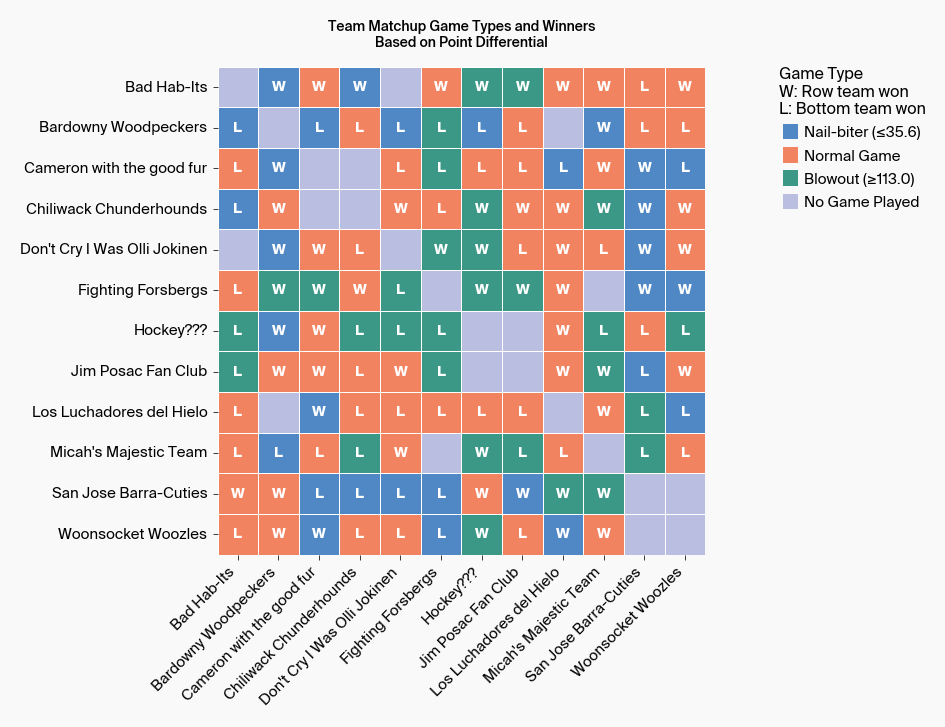

In [18]:
def plot_matchup_type_matrix(raw_data, save_path=None):
    """Create a heatmap showing game types (nail-biter/normal/blowout) for each team matchup."""
    # Calculate point differential for each game
    raw_data['Point_Differential'] = abs(raw_data['Team 1 Points'] - raw_data['Team 2 Points'])
    
    # Define thresholds for close games and blowouts
    close_threshold = float(raw_data['Point_Differential'].quantile(0.25))  # Bottom 25% are "close"
    blowout_threshold = float(raw_data['Point_Differential'].quantile(0.75))  # Top 25% are "blowouts"
    
    # Categorize games
    def categorize_game(diff):
        if diff <= close_threshold:
            return 1  # Nail-biter
        elif diff >= blowout_threshold:
            return 3  # Blowout
        else:
            return 2  # Normal game
    
    raw_data['Game_Type'] = raw_data['Point_Differential'].apply(categorize_game)
    
    # Get all teams and sort them
    all_teams = sorted(list(set(raw_data['Team 1 Name'].unique()) | set(raw_data['Team 2 Name'].unique())))
    n_teams = len(all_teams)
    
    # Create empty matrices for heatmap and winners
    matchup_matrix = np.full((n_teams, n_teams), np.nan)
    winner_matrix = np.full((n_teams, n_teams), '', dtype=object)
    
    # Fill matrices with the entire cell, not just winner
    for _, row in raw_data.iterrows():
        team1_idx = all_teams.index(row['Team 1 Name'])
        team2_idx = all_teams.index(row['Team 2 Name'])
        
        # Add game type to both positions in matrix
        matchup_matrix[team1_idx, team2_idx] = row['Game_Type']
        matchup_matrix[team2_idx, team1_idx] = row['Game_Type']
        
        # Determine winner and add X/Y annotations
        if row['Team 1 Points'] > row['Team 2 Points']:
            # Team 1 won
            winner_matrix[team1_idx, team2_idx] = row
            winner_matrix[team2_idx, team1_idx] = row
        else:
            # Team 2 won
            winner_matrix[team1_idx, team2_idx] = row
            winner_matrix[team2_idx, team1_idx] = row
    
    # Create figure with eggshell white background
    plt.figure(figsize=(12, 10))
    fig = plt.gcf()
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#BABEE0')
    
    # Create custom colormap
    colors = ['#5088C5', '#F28360', '#3B9886']  # Green (nail-biter), Blue (normal), Red (blowout)
    custom_cmap = ListedColormap(colors)
    
    # Create heatmap
    sns.heatmap(matchup_matrix,
                xticklabels=all_teams,
                yticklabels=all_teams,
                cmap=custom_cmap,
                center=2,
                vmin=1,
                vmax=3,
                cbar=False,
                square=True,
                linewidths=1,
                linecolor='white',
                mask=np.isnan(matchup_matrix),
                ax=ax)
    
# Add winner annotations based on actual game outcomes
    for i in range(n_teams):
        for j in range(n_teams):
            if not np.isnan(matchup_matrix[i, j]):
                game = winner_matrix[i, j]
                row_team = all_teams[i]
                
                # Determine if row team won
                if row_team == game['Team 1 Name']:
                    won = game['Team 1 Points'] > game['Team 2 Points']
                else:
                    won = game['Team 2 Points'] > game['Team 1 Points']
                
                # Place Y if row team lost (column team won), X if row team won
                winner_text = 'L' if not won else 'W'  # Flipped the logic here
                ax.text(j + 0.5, i + 0.5, winner_text,
                    ha='center', va='center',
                    color='white', fontweight='bold')
    
    # Add custom legend
    legend_elements = [Patch(facecolor='#5088C5', label='Nail-biter (≤{:.1f})'.format(close_threshold)),
                      Patch(facecolor='#F28360', label='Normal Game'),
                      Patch(facecolor='#3B9886', label='Blowout (≥{:.1f})'.format(blowout_threshold)),
                      Patch(facecolor='#BABEE0', label='No Game Played')]
    ax.legend(handles=legend_elements, title='Game Type\nW: Row team won\nL: Bottom team won', 
             bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # Customize plot
    ax.set_title('Team Matchup Game Types and Winners\nBased on Point Differential',
                fontsize=14, pad=20)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()
    
    return matchup_matrix, winner_matrix

# Usage
matchup_matrix, winner_matrix = plot_matchup_type_matrix(raw_data, f"{OUTPUT_DIR}matchup_type_matrix.png")

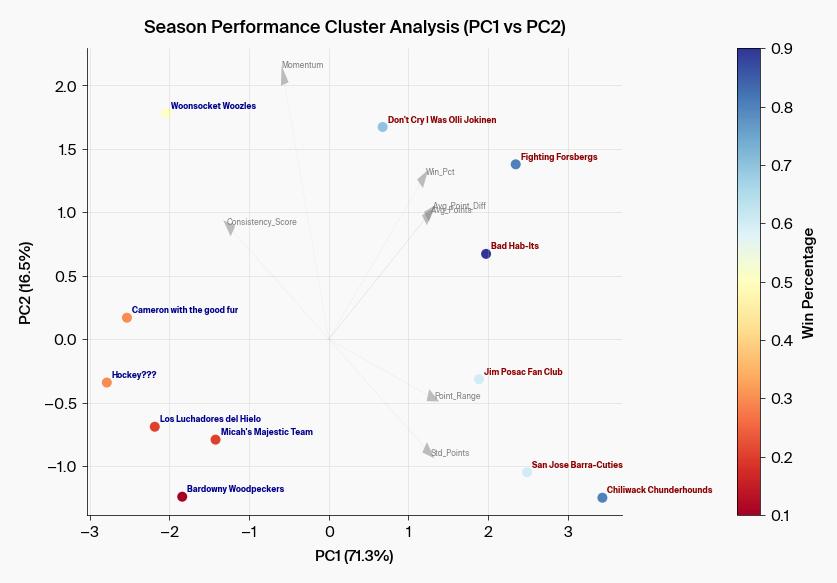

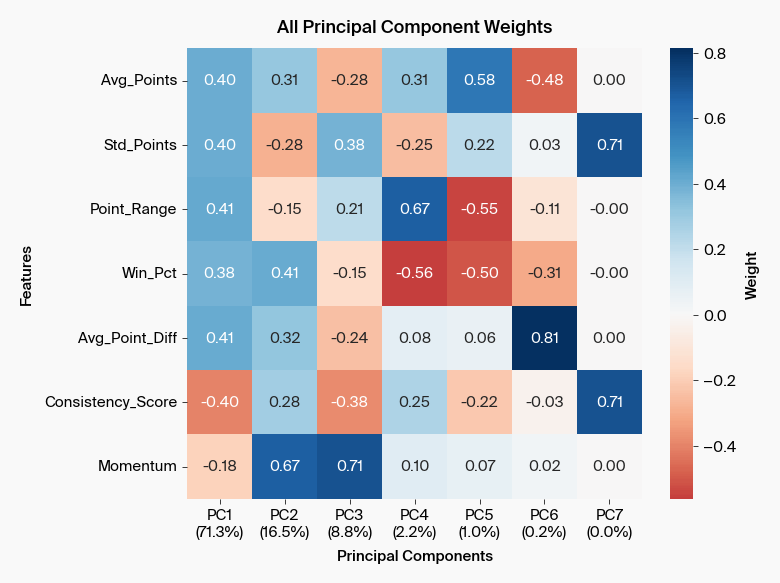


Explained Variance Summary:
PC1: 71.3% of variance explained
PC2: 16.5% of variance explained
PC3: 8.8% of variance explained
PC4: 2.2% of variance explained
PC5: 1.0% of variance explained
PC6: 0.2% of variance explained
PC7: 0.0% of variance explained
Total variance explained by first 3 PCs: 96.7%


In [19]:
def calculate_momentum(team_stats, team):
    """Calculate momentum score based on point differential trends."""
    points = team_stats[team]['weekly_points']
    
    # Calculate momentum as trend in last 3 games
    if len(points) >= 3:
        last_3_trend = points[-1] - points[-3]
    else:
        last_3_trend = 0
        
    # Normalize by max point differential
    max_diff = max(abs(team_stats[t]['point_differential']) for t in team_stats.keys())
    return last_3_trend / max_diff if max_diff != 0 else 0

def create_feature_df(team_stats):
    """Create feature DataFrame for PCA analysis."""
    features = []
    
    # Find max std dev for normalization
    max_std = max(stats['std_points'] for stats in team_stats.values())
    
    for team, stats in team_stats.items():
        # Calculate point range
        points = stats['weekly_points']
        point_range = max(points) - min(points)
        
        # Calculate consistency score (inverse of std dev, normalized)
        consistency_score = 1 - (stats['std_points'] / max_std) if max_std != 0 else 1
        
        # Calculate momentum
        momentum_score = calculate_momentum(team_stats, team)
        
        features.append({
            'Team': team,
            'Avg_Points': stats['avg_points'],
            'Std_Points': stats['std_points'],
            'Point_Range': point_range,
            'Win_Pct': stats['win_rate'] / 100,  # Convert to decimal
            'Avg_Point_Diff': stats['point_differential'] / len(points),
            'Consistency_Score': consistency_score,
            'Momentum': momentum_score
        })
    
    return pd.DataFrame(features)

def perform_pca_analysis(scaled_features, feature_df, save_path=None):
    """Perform PCA analysis on team performance metrics with multiple visualizations."""
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    
    # Define feature names
    feature_names = ['Avg_Points', 'Std_Points', 'Point_Range', 
                    'Win_Pct', 'Avg_Point_Diff', 'Consistency_Score', 'Momentum']
    
    # Create multiple PC biplots for different component combinations
    pc_combinations = [(0,1)] #, (0,2), (1,2), (0,3), (5,6), (0,4), (0,5), (0,6), (1,3), (1,4), (1,5), (1,6), (2,3), (2,4), (2,5), (2,6), (3, 4), (3,5), (3,6), (4,5), (4,6)]  # PC1 vs PC2, PC1 vs PC3, PC2 vs PC3
    
    for pc1_idx, pc2_idx in pc_combinations:
        plt.figure(figsize=(12, 8))
        fig = plt.gcf()
        fig.patch.set_facecolor('#F9F9F9')
        ax = plt.gca()
        ax.set_facecolor('#F9F9F9')
        
        # Plot teams
        scatter = plt.scatter(pca_result[:, pc1_idx], pca_result[:, pc2_idx],
                            c=feature_df['Win_Pct'],
                            cmap='RdYlBu',
                            s=100)
        colorbar = plt.colorbar(scatter, label='Win Percentage', 
                              orientation='vertical',
                              pad=0.15)
        
        # Add team labels
        for i, team in enumerate(feature_df['Team']):
            win_pct = feature_df.iloc[i]['Win_Pct']
            color = 'darkred' if win_pct > 0.5 else 'darkblue'
            plt.annotate(team, 
                        (pca_result[i, pc1_idx], pca_result[i, pc2_idx]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        color=color,
                        fontsize=8,
                        fontweight='bold')
        
        # Add feature vectors
        for i, feature in enumerate(feature_names):
            plt.arrow(0, 0, 
                     pca.components_[pc1_idx, i] * 3, 
                     pca.components_[pc2_idx, i] * 3,
                     color='gray',
                     alpha=0.5,
                     head_width=0.1)
            plt.text(pca.components_[pc1_idx, i] * 3.2, 
                    pca.components_[pc2_idx, i] * 3.2, 
                    feature,
                    color='gray',
                    fontsize=8)
        
        plt.xlabel(f'PC{pc1_idx+1} ({explained_variance[pc1_idx]:.1%})')
        plt.ylabel(f'PC{pc2_idx+1} ({explained_variance[pc2_idx]:.1%})')
        plt.title(f'Season Performance Cluster Analysis (PC{pc1_idx+1} vs PC{pc2_idx+1})')
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(f"{save_path}_biplot_PC{pc1_idx+1}_PC{pc2_idx+1}.png", 
                       dpi=300, bbox_inches='tight', facecolor='#F9F9F9')
        plt.tight_layout()
        plt.show()
    
    # Create heatmap of all PC weights
    plt.figure(figsize=(12, 8))
    fig = plt.gcf()
    fig.patch.set_facecolor('#F9F9F9')
    
    loadings_df = pd.DataFrame(
        pca.components_.T,  # All components
        columns=[f'PC{i+1}\n({var:.1%})' for i, var in enumerate(explained_variance)],
        index=feature_names
    )
    
    # Create heatmap with legend on the right
    g = sns.heatmap(loadings_df, 
                    cmap='RdBu',
                    center=0,
                    annot=True,
                    fmt='.2f',
                    cbar_kws={'label': 'Weight'},
                    cbar=True)
    
    # Move colorbar to the right
    g.figure.axes[-1].set_position([.92, .3, .03, .4])
    
    plt.title('All Principal Component Weights')
    plt.ylabel('Features')
    plt.xlabel('Principal Components')
    
    if save_path:
        plt.savefig(f"{save_path}_all_weights.png", dpi=300, bbox_inches='tight', facecolor='#F9F9F9')
    plt.tight_layout()
    plt.show()
    
    # Print explained variance summary
    print("\nExplained Variance Summary:")
    for i, var in enumerate(explained_variance):
        print(f"PC{i+1}: {var:.1%} of variance explained")
    print(f"Total variance explained by first 3 PCs: {sum(explained_variance[:3]):.1%}")
    
    return pca, pca_result

# Usage:
# First create the feature DataFrame
feature_df = create_feature_df(team_stats)

# Prepare and scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df.drop('Team', axis=1))

# Perform PCA analysis
pca, pca_result = perform_pca_analysis(scaled_features, feature_df, f"{OUTPUT_DIR}pca_analysis")


Vulnerability Analysis Components:

Hockey???:
Total Vulnerability Score: 129.5
- Inconsistency Impact: 24.5 (Standard Deviation * 0.5)
- Close Win Impact: 0.0 (Close Win Rate * 2)
- Blowout Impact: 105.0 (Blowout Rate * 1.5)
Games: 10 | Close Wins: 0 | Blowout Losses: 7

Cameron with the good fur:
Total Vulnerability Score: 121.4
- Inconsistency Impact: 21.4 (Standard Deviation * 0.5)
- Close Win Impact: 40.0 (Close Win Rate * 2)
- Blowout Impact: 60.0 (Blowout Rate * 1.5)
Games: 10 | Close Wins: 2 | Blowout Losses: 4

Los Luchadores del Hielo:
Total Vulnerability Score: 119.0
- Inconsistency Impact: 24.0 (Standard Deviation * 0.5)
- Close Win Impact: 20.0 (Close Win Rate * 2)
- Blowout Impact: 75.0 (Blowout Rate * 1.5)
Games: 10 | Close Wins: 1 | Blowout Losses: 5

Micah's Majestic Team:
Total Vulnerability Score: 101.0
- Inconsistency Impact: 26.0 (Standard Deviation * 0.5)
- Close Win Impact: 0.0 (Close Win Rate * 2)
- Blowout Impact: 75.0 (Blowout Rate * 1.5)
Games: 10 | Close Wi

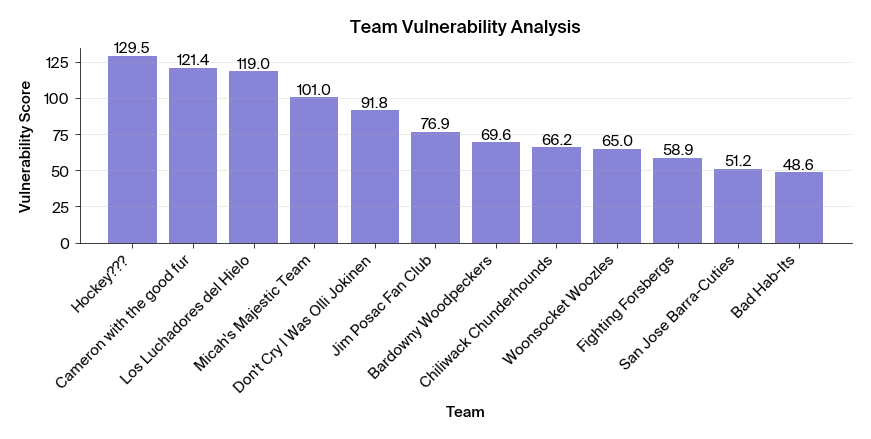

In [20]:
def analyze_team_vulnerability(raw_data):
    """
    Analyze team vulnerability based on scoring inconsistency, close wins, and blowout losses.
    Returns a DataFrame with vulnerability metrics and components.
    """
    team_stats = {}
    
    # Calculate team stats
    for _, row in raw_data.iterrows():
        for team_idx, team_key in enumerate(['Team 1 Name', 'Team 2 Name']):
            points_key = f'Team {team_idx + 1} Points'
            opp_points_key = f'Team {2 - team_idx} Points'
            team_name = row[team_key]
            points = row[points_key]
            opp_points = row[opp_points_key]
            
            if team_name not in team_stats:
                team_stats[team_name] = {
                    'games': 0,
                    'points': [],
                    'opp_points': [],
                    'blowout_losses': 0,
                    'close_wins': 0
                }
            
            team_stats[team_name]['games'] += 1
            team_stats[team_name]['points'].append(points)
            team_stats[team_name]['opp_points'].append(opp_points)
            
            # Track blowout losses (50+ point loss) and close wins (<20 point win)
            if opp_points - points >= 50:
                team_stats[team_name]['blowout_losses'] += 1
            if points - opp_points > 0 and points - opp_points < 20:
                team_stats[team_name]['close_wins'] += 1

    # Calculate vulnerability metrics
    vulnerability_metrics = []
    for team, stats in team_stats.items():
        avg_points = np.mean(stats['points'])
        std_dev = np.std(stats['points'])
        blowout_rate = (stats['blowout_losses'] / stats['games']) * 100
        close_win_rate = (stats['close_wins'] / stats['games']) * 100
        
        # Calculate vulnerability index using the same weights as the React component
        vulnerability_index = (std_dev * 0.5) + (close_win_rate * 2) + (blowout_rate * 1.5)
        
        vulnerability_metrics.append({
            'Team': team,
            'Vulnerability_Index': round(vulnerability_index, 1),
            'Inconsistency': round(std_dev * 0.5, 1),
            'Close_Win_Factor': round(close_win_rate * 2, 1),
            'Blowout_Impact': round(blowout_rate * 1.5, 1),
            'Games_Played': stats['games'],
            'Blowout_Losses': stats['blowout_losses'],
            'Close_Wins': stats['close_wins']
        })
    
    # Create DataFrame and sort by vulnerability index
    vulnerability_df = pd.DataFrame(vulnerability_metrics)
    vulnerability_df = vulnerability_df.sort_values('Vulnerability_Index', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    bars = plt.bar(vulnerability_df['Team'], vulnerability_df['Vulnerability_Index'])
    
    # Color the bars
    for i, bar in enumerate(bars):
        if vulnerability_df.iloc[i]['Team'] == 'San Jose Barra-Cuties':
            bar.set_color('#8884d8')
        else:
            bar.set_color('#8884d8')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Team Vulnerability Analysis')
    plt.xlabel('Team')
    plt.ylabel('Vulnerability Score')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, v in enumerate(vulnerability_df['Vulnerability_Index']):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Print detailed analysis
    print("\nVulnerability Analysis Components:")
    print("=" * 80)
    for _, row in vulnerability_df.iterrows():
        print(f"\n{row['Team']}:")
        print(f"Total Vulnerability Score: {row['Vulnerability_Index']}")
        print(f"- Inconsistency Impact: {row['Inconsistency']} (Standard Deviation * 0.5)")
        print(f"- Close Win Impact: {row['Close_Win_Factor']} (Close Win Rate * 2)")
        print(f"- Blowout Impact: {row['Blowout_Impact']} (Blowout Rate * 1.5)")
        print(f"Games: {row['Games_Played']} | Close Wins: {row['Close_Wins']} | Blowout Losses: {row['Blowout_Losses']}")
    
    return vulnerability_df

# Run the analysis
vulnerability_analysis = analyze_team_vulnerability(raw_data)

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/900686387.py:49: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) Suisse Int'l.
  plt.tight_layout()
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/900686387.py:49: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Suisse Int'l.
  plt.tight_layout()
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/900686387.py:52: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) Suisse Int'l.
  plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/900686387.py:52: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Suisse Int'l.
  plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
/Users/cameronmacquarrie/miniforge3/envs/caiman/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 

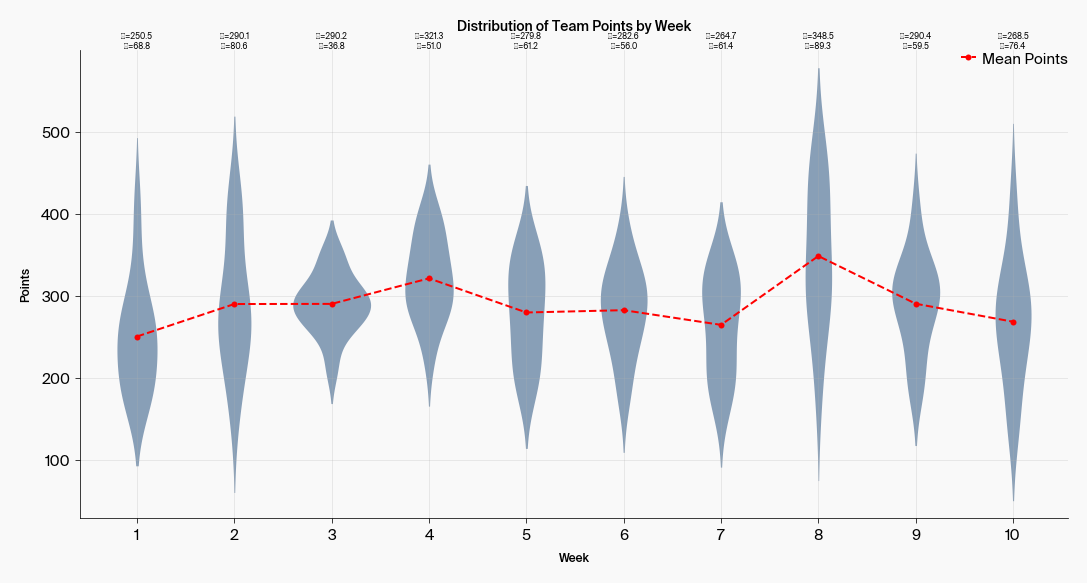


Weekly Scoring Statistics:

Week 1:
Mean Points: 250.5
Std Dev: 68.8
Range: 176.7 - 409.1
Spread: 232.4 points

Week 2:
Mean Points: 290.1
Std Dev: 80.6
Range: 158.6 - 420.9
Spread: 262.3 points

Week 3:
Mean Points: 290.2
Std Dev: 36.8
Range: 213.6 - 347.7
Spread: 134.1 points

Week 4:
Mean Points: 321.3
Std Dev: 51.0
Range: 227.8 - 398.4
Spread: 170.6 points

Week 5:
Mean Points: 279.8
Std Dev: 61.2
Range: 188.7 - 360.0
Spread: 171.3 points

Week 6:
Mean Points: 282.6
Std Dev: 56.0
Range: 177.6 - 377.3
Spread: 199.7 points

Week 7:
Mean Points: 264.7
Std Dev: 61.4
Range: 166.1 - 340.0
Spread: 173.9 points

Week 8:
Mean Points: 348.5
Std Dev: 89.3
Range: 183.8 - 469.2
Spread: 285.4 points

Week 9:
Mean Points: 290.4
Std Dev: 59.5
Range: 190.2 - 401.4
Spread: 211.2 points

Week 10:
Mean Points: 268.5
Std Dev: 76.4
Range: 143.5 - 417.2
Spread: 273.7 points


In [21]:
def plot_weekly_points_distribution(raw_data, save_path=None):
    """Create a violin plot showing the distribution of points for each week."""
    # Create long format dataframe of all points
    weekly_points = pd.DataFrame({
        'Week': raw_data['Week'].tolist() * 2,
        'Points': pd.concat([raw_data['Team 1 Points'], raw_data['Team 2 Points']]).tolist()
    })

    # Create figure with eggshell white background
    plt.figure(figsize=(15, 8))
    fig = plt.gcf()
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Create violin plot
    sns.violinplot(data=weekly_points, 
                  x='Week', 
                  y='Points',
                  color='#4E79A7',
                  inner='box',  # Show box plot inside violin
                  alpha=0.7)
    
    # Add weekly statistics
    weekly_stats = weekly_points.groupby('Week')['Points'].agg(['mean', 'std', 'min', 'max'])
    
    # Add mean points line
    plt.plot(range(len(weekly_stats)), weekly_stats['mean'], 
             color='red', linestyle='--', label='Mean Points', 
             linewidth=2, marker='o')
    
    # Customize plot
    plt.title('Distribution of Team Points by Week', fontsize=14, pad=20)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Points', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add statistical annotations
    for week in range(len(weekly_stats)):
        stats = weekly_stats.iloc[week]
        plt.text(week, plt.ylim()[1], 
                f'μ={stats["mean"]:.1f}\nσ={stats["std"]:.1f}', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()
    
    # Print weekly statistics
    print("\nWeekly Scoring Statistics:")
    print("=" * 80)
    for week, stats in weekly_stats.iterrows():
        print(f"\nWeek {week}:")
        print(f"Mean Points: {stats['mean']:.1f}")
        print(f"Std Dev: {stats['std']:.1f}")
        print(f"Range: {stats['min']:.1f} - {stats['max']:.1f}")
        print(f"Spread: {stats['max'] - stats['min']:.1f} points")

# Usage
plot_weekly_points_distribution(raw_data, f"{OUTPUT_DIR}weekly_points_distribution.png")

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/3851304201.py:65: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) Suisse Int'l.
  plt.tight_layout()
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/3851304201.py:65: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Suisse Int'l.
  plt.tight_layout()
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/3851304201.py:68: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) Suisse Int'l.
  plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_70713/3851304201.py:68: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Suisse Int'l.
  plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
/Users/cameronmacquarrie/miniforge3/envs/caiman/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Gl

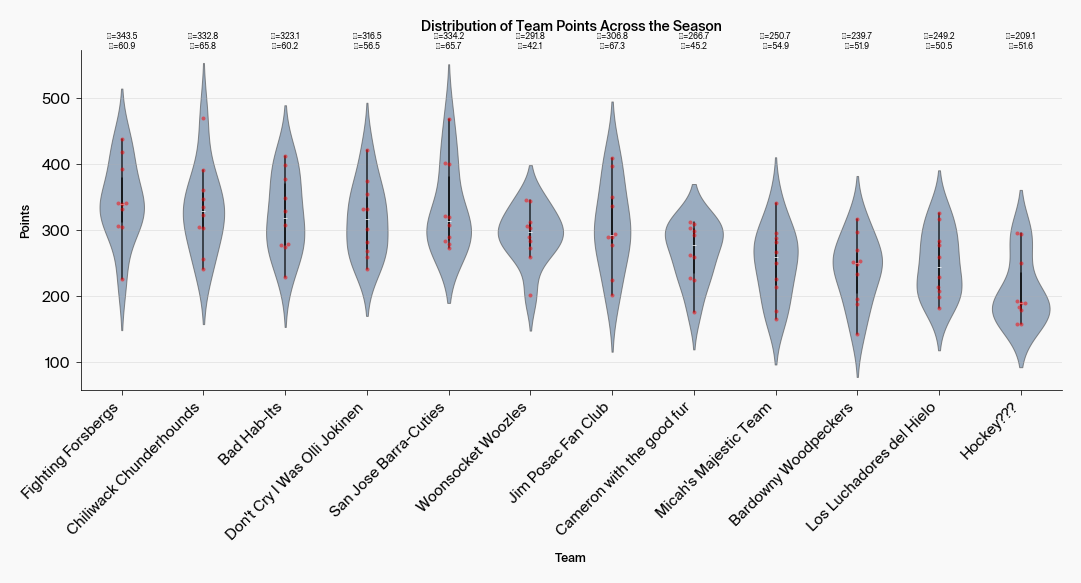


Team Scoring Statistics (sorted by median points):

Fighting Forsbergs:
Median Points: 339.7
Mean Points: 343.5
Std Dev: 60.9
Range: 225.6 - 436.7
Spread: 211.1 points

Chiliwack Chunderhounds:
Median Points: 328.1
Mean Points: 332.8
Std Dev: 65.8
Range: 240.9 - 469.2
Spread: 228.3 points

Bad Hab-Its:
Median Points: 317.6
Mean Points: 323.1
Std Dev: 60.2
Range: 229.5 - 412.4
Spread: 182.9 points

Don't Cry I Was Olli Jokinen:
Median Points: 316.6
Mean Points: 316.5
Std Dev: 56.5
Range: 241.5 - 420.9
Spread: 179.4 points

San Jose Barra-Cuties:
Median Points: 314.0
Mean Points: 334.2
Std Dev: 65.7
Range: 272.8 - 467.4
Spread: 194.6 points

Woonsocket Woozles:
Median Points: 296.5
Mean Points: 291.8
Std Dev: 42.1
Range: 201.2 - 344.8
Spread: 143.6 points

Jim Posac Fan Club:
Median Points: 291.9
Mean Points: 306.8
Std Dev: 67.3
Range: 201.1 - 409.1
Spread: 208.0 points

Cameron with the good fur:
Median Points: 277.6
Mean Points: 266.7
Std Dev: 45.2
Range: 176.7 - 312.4
Spread: 135.7 p

In [22]:
def plot_team_points_distribution(raw_data, all_teams_data, save_path=None):
    """Create a violin plot showing the distribution of points for each team across the season."""
    # Create figure with eggshell white background
    plt.figure(figsize=(15, 8))
    fig = plt.gcf()
    fig.patch.set_facecolor('#F9F9F9')
    ax = plt.gca()
    ax.set_facecolor('#F9F9F9')
    
    # Setup Arcadia color scheme
    apc.mpl.setup()
    
    # Sort teams by median points to make visualization more interpretable
    team_medians = all_teams_data.groupby('Team')['Points'].median().sort_values(ascending=False)
    sorted_teams = team_medians.index.tolist()
    
    # Create violin plot with box plot inside
    violin_plot = sns.violinplot(data=all_teams_data, 
                               x='Team', 
                               y='Points',
                               order=sorted_teams,
                               inner='box',  # Show standard box plot inside
                               width=0.8,    # Adjust violin width
                               linewidth=1,  # Width of violin outline
                               saturation=0.7, # Color saturation
                               color='#4E79A7',
                               alpha=0.6)
    
    # Customize boxplot elements
    for lines in violin_plot.lines:
        lines.set_linestyle('-')
        lines.set_linewidth(1.5)
        lines.set_color('black')
        lines.set_alpha(0.8)
    
    # Add individual points for outliers
    sns.swarmplot(data=all_teams_data,
                 x='Team',
                 y='Points',
                 order=sorted_teams,
                 color='red',
                 alpha=0.5,
                 size=4,
                 dodge=True)
    
    # Calculate and add team statistics
    team_stats = all_teams_data.groupby('Team')['Points'].agg(['mean', 'std', 'min', 'max', 'median'])
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Customize plot
    plt.title('Distribution of Team Points Across the Season', fontsize=14, pad=20)
    plt.xlabel('Team', fontsize=12)
    plt.ylabel('Points', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add statistical annotations
    for i, team in enumerate(sorted_teams):
        stats = team_stats.loc[team]
        plt.text(i, plt.ylim()[1], 
                f'μ={stats["mean"]:.1f}\nσ={stats["std"]:.1f}', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='#F9F9F9', bbox_inches='tight')
    plt.show()
    
    # Print team statistics
    print("\nTeam Scoring Statistics (sorted by median points):")
    print("=" * 80)
    for team in sorted_teams:
        stats = team_stats.loc[team]
        print(f"\n{team}:")
        print(f"Median Points: {stats['median']:.1f}")
        print(f"Mean Points: {stats['mean']:.1f}")
        print(f"Std Dev: {stats['std']:.1f}")
        print(f"Range: {stats['min']:.1f} - {stats['max']:.1f}")
        print(f"Spread: {stats['max'] - stats['min']:.1f} points")

# Usage
plot_team_points_distribution(raw_data, all_teams_data, f"{OUTPUT_DIR}team_points_distribution.png")

In [23]:
def create_interactive_html_plot(all_teams_data, team_stats, output_file='team_performance.html'):
    """Create and save an interactive plot as HTML using Plotly."""
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Create figure
    fig = go.Figure()
    
    # Sort teams by differential for consistent coloring
    teams_by_diff = sorted(team_stats.items(), 
                          key=lambda x: x[1]['point_differential'],
                          reverse=True)
    team_order = [team[0] for team in teams_by_diff]
    
    # Setup colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(team_order)))
    
    # Add traces for each team
    for i, team in enumerate(team_order):
        team_data = all_teams_data[all_teams_data['Team'] == team]
        
        fig.add_trace(
            go.Scatter(
                x=team_data['Week'],
                y=team_data['Points'],
                name=team,
                mode='lines+markers',
                line=dict(color=f'rgba({int(colors[i][0]*255)},{int(colors[i][1]*255)},{int(colors[i][2]*255)},{colors[i][3]})'),
                marker=dict(size=8),
                visible=False  # Start with all teams hidden
            )
        )
    
    # Create HTML buttons for multi-selection
    buttons_html = """
    <div style="position: absolute; top: 10px; left: 10px; z-index: 1000; background-color: white; padding: 10px; border-radius: 5px; box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
        <div style="margin-bottom: 10px;">
            <button onclick="showAll()">Show All</button>
            <button onclick="hideAll()">Hide All</button>
        </div>
        <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 5px;">
    """
    
    for i, team in enumerate(team_order):
        buttons_html += f"""
        <button id="btn_{i}" onclick="toggleTeam({i})" style="margin: 2px; padding: 5px;">{team}</button>
        """
    
    buttons_html += """
        </div>
    </div>
    
    <script>
        let visibleTeams = new Set();
        
        function updatePlot() {
            const update = {
                visible: Array(_{len(team_order)}).fill(false)
            };
            visibleTeams.forEach(i => update.visible[i] = true);
            Plotly.update('plotly-html-element', update);
        }
        
        function toggleTeam(index) {
            const btn = document.getElementById(`btn_${index}`);
            if (visibleTeams.has(index)) {
                visibleTeams.delete(index);
                btn.style.backgroundColor = '';
            } else {
                visibleTeams.add(index);
                btn.style.backgroundColor = 'lightblue';
            }
            updatePlot();
        }
        
        function showAll() {
            visibleTeams = new Set([...Array(_{len(team_order)}).keys()]);
            document.querySelectorAll('button[id^="btn_"]').forEach(btn => {
                btn.style.backgroundColor = 'lightblue';
            });
            updatePlot();
        }
        
        function hideAll() {
            visibleTeams.clear();
            document.querySelectorAll('button[id^="btn_"]').forEach(btn => {
                btn.style.backgroundColor = '';
            });
            updatePlot();
        }
    </script>
    """
    
    # Update layout
    fig.update_layout(
        title='Weekly Points by Team',
        xaxis_title='Week',
        yaxis_title='Points',
        plot_bgcolor='#F9F9F9',
        paper_bgcolor='#F9F9F9',
        hovermode='x unified',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05
        ),
        width=1200,
        height=800,
        margin=dict(t=100, r=150, b=50, l=50)  # Increased top margin for buttons
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     tickmode='linear', tick0=min(all_teams_data['Week']), dtick=1)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)')
    
    # Add hover template
    fig.update_traces(
        hovertemplate="<b>%{fullData.name}</b><br>" +
                      "Week: %{x}<br>" +
                      "Points: %{y:.1f}<br>"
    )
    
    # Save to HTML file with custom buttons
    with open(output_file, 'w') as f:
        f.write(fig.to_html(
            include_plotlyjs=True,
            full_html=True,
            post_script=buttons_html
        ))
    
    print(f"Interactive plot saved to {output_file}")
    
    # Also display in notebook
    return fig

# Usage
fig = create_interactive_html_plot(all_teams_data, team_stats, 'fantasy_hockey_performance.html')
fig.show()

Interactive plot saved to fantasy_hockey_performance.html


In [24]:
def create_interactive_html_plot(all_teams_data, team_stats, output_file='team_performance.html'):
    """Create and save an interactive plot as HTML using Plotly."""
    import plotly.graph_objects as go
    
    # Create figure
    fig = go.Figure()
    
    # Sort teams by differential for consistent coloring
    teams_by_diff = sorted(team_stats.items(), 
                          key=lambda x: x[1]['point_differential'],
                          reverse=True)
    team_order = [team[0] for team in teams_by_diff]
    
    # Setup colors using a fixed color scheme
    colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
    ]
    
    # Add line for each team (initially hidden)
    for i, team in enumerate(team_order):
        team_data = all_teams_data[all_teams_data['Team'] == team]
        
        fig.add_trace(
            go.Scatter(
                x=team_data['Week'],
                y=team_data['Points'],
                name=team,
                mode='lines+markers',
                line=dict(
                    color=colors[i % len(colors)],
                    width=2
                ),
                marker=dict(
                    size=8,
                    symbol='circle'
                ),
                visible='legendonly'  # This makes them toggleable in legend but initially hidden
            )
        )

    # Update layout
    fig.update_layout(
        title={
            'text': 'Weekly Points by Team',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        xaxis_title='Week',
        yaxis_title='Points',
        plot_bgcolor='#F9F9F9',
        paper_bgcolor='#F9F9F9',
        hovermode='x unified',
        showlegend=True,
        legend=dict(
            title=dict(text='Teams'),
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(0, 0, 0, 0.2)',
            borderwidth=1
        ),
        width=1200,
        height=800,
        margin=dict(r=200, t=100, b=50, l=50),  # Increased right margin for legend
        xaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(128,128,128,0.2)',
            tickmode='linear',
            tick0=min(all_teams_data['Week']),
            dtick=1,
            title_font=dict(size=14),
            tickfont=dict(size=12)
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(128,128,128,0.2)',
            title_font=dict(size=14),
            tickfont=dict(size=12)
        ),
    )
    
    # Improve hover template
    fig.update_traces(
        hovertemplate="<b>%{fullData.name}</b><br>" +
                      "Week: %{x}<br>" +
                      "Points: %{y:.1f}<br>" +
                      "<extra></extra>"  # Removes secondary box
    )
    
    # Save to HTML file
    fig.write_html(output_file, 
                  include_plotlyjs=True,
                  full_html=True,
                  config={
                      'displayModeBar': True,
                      'displaylogo': False,
                      'modeBarButtonsToRemove': ['lasso2d', 'select2d']
                  })
    
    print(f"Interactive plot saved to {output_file}")
    return fig

# Usage
fig = create_interactive_html_plot(all_teams_data, team_stats, 'fantasy_hockey_performance.html')
fig.show()

Interactive plot saved to fantasy_hockey_performance.html
